In [ ]:
%load_ext autoreload
%autoreload 2

# Text: Core

> The `text.core` module contains the core bits required to use fast.ai's low-level and/or mid-level APIs to define `Datasets`, build `DataLoaders`, and train text/NLP models with fast.ai

In [ ]:
# |default_exp text.core.data
# |default_cls_lvl 3

In [ ]:
# |export
from __future__ import annotations

import gc, importlib, sys, traceback

from accelerate.logging import get_logger
from dataclasses import dataclass
from datasets import concatenate_datasets, load_dataset
from dotenv import load_dotenv
from fastai.callback.all import *
from fastai.imports import *
from fastai.learner import *
from fastai.losses import BaseLoss, BCEWithLogitsLossFlat, CrossEntropyLossFlat
from fastai.data.block import TransformBlock
from fastai.data.transforms import DataLoader, DataLoaders, Datasets, ColSplitter, ItemTransform, TfmdDL
from fastai.optimizer import Adam, OptimWrapper, params
from fastai.metrics import accuracy, F1Score, accuracy_multi, F1ScoreMulti
from fastai.test_utils import show_install
from fastai.torch_core import *
from fastai.torch_imports import *
from transformers import AutoConfig, AutoTokenizer, PretrainedConfig, PreTrainedTokenizerBase, PreTrainedModel
from transformers import AutoModelForSequenceClassification
from transformers import logging as hf_logging
from transformers.data.data_collator import DataCollatorWithPadding

from blurr.utils import clean_memory, get_hf_objects, set_seed, PreCalculatedLoss

In [ ]:
# |hide
import pdb

from datasets import Value
from fastai.data.block import MultiCategoryBlock, CategoryBlock, ColReader, ColSplitter, DataBlock, ItemGetter, RandomSplitter, FuncSplitter
from fastai.text.data import SortedDL
from fastcore.test import *
import nbdev

from blurr.utils import print_versions, PreCalculatedCrossEntropyLoss, PreCalculatedBCELoss, PreCalculatedMSELoss

In [ ]:
# |export
# silence all the HF warnings and load environment variables
warnings.simplefilter("ignore")
hf_logging.set_verbosity_error()
logger = get_logger(__name__)

load_dotenv()

False

In [ ]:
# |hide
# |notest
torch.cuda.set_device(0)
print(f"Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}")

Using GPU #0: NVIDIA GeForce RTX 3090


In [ ]:
# | echo: false
os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("What we're running with at the time this documentation was generated:")
print_versions("torch fastai transformers")

What we're running with at the time this documentation was generated:
torch: 1.13.1
fastai: 2.7.11
transformers: 4.26.1


## Setup

We'll use a subset of `imdb` to demonstrate how to configure your BLURR for sequence classification tasks. **BLURR** is designed to work with Hugging Face `Dataset` and/or pandas `DataFrame` objects

In [ ]:
def get_new_hf_objects(labels):
    model_cls = AutoModelForSequenceClassification
    hf_logging.set_verbosity_error()

    pretrained_model_name = "microsoft/deberta-v3-small"
    n_labels = len(labels)

    hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(
        pretrained_model_name, model_cls=model_cls, config_kwargs={"num_labels": n_labels}
    )

    hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

    print("=== config ===")
    print(f"# of labels:\t{hf_config.num_labels}")
    print("")
    print("=== tokenizer ===")
    print(f"Vocab size:\t\t{hf_tokenizer.vocab_size}")
    print(f"Max # of tokens:\t{hf_tokenizer.model_max_length}")
    print(f"Attributes expected by model in forward pass:\t{hf_tokenizer.model_input_names}")

    return hf_arch, hf_config, hf_tokenizer, hf_model

### Multiclass

In [ ]:
imdb_dsd = load_dataset("imdb", split=["train", "test"])

# build HF `Dataset` objects
train_ds = imdb_dsd[0].add_column("is_valid", [False] * len(imdb_dsd[0])).shuffle().select(range(1000))
valid_ds = imdb_dsd[1].add_column("is_valid", [True] * len(imdb_dsd[1])).shuffle().select(range(200))
imdb_ds = concatenate_datasets([train_ds, valid_ds])

# build a `DataFrame` representation as well
imdb_df = pd.DataFrame(imdb_ds)

print(len(train_ds), len(valid_ds))
print(len(imdb_df[imdb_df["is_valid"] == False]), len(imdb_df[imdb_df["is_valid"] == True]))
imdb_df.head()

Found cached dataset imdb (/home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/2 [00:00<?, ?it/s]

1000 200
1000 200


,text,label,is_valid
0,"Being a music student myself, I thought a movie taking place in a conservatory might be fun to watch. Little did I know... (I had no idea this movie was based on a book by Britney Spears) This movie was implausible throughout. It's obvious that whoever wrote the script never set foot in a conservatory and doesn't know a thing about classical music. Let me give you just a few examples: 1) There is NO WAY anyone would be admitted to a classical conservatory with no classical training whatsoever! Just having a nice pop voice isn't enough, besides, that's a different thing altogether - another...",0,False
1,"Starring an unknown cast which seem likely to remain that way, this ""film"" is yet another cheap slasher flick which amazes me how this was released. I have no problem with horrors and slasher flicks in particular, in fact they are my favourites. But when they are done THIS BAD, it really does take the monkey and its no wonder the genre has such a hard time. The story is as clichéd and without imagination as possible with a bunch of people in a cabin out in the woods being slashed and hacked up by this zombie/ghost guy. Its not the story that sucks the most, its the atrocious acting and dia...",0,False
2,"This is the best of the 43 films that Rainer Werner Fassbinder made; his most successful at least. He was one of the leading directors in the New Germany after WWII.<br /><br />Hanna Schygulla was magnificent as the cold, calculating Maria Bruan, who lost her husband to the War, found him after she took an American soldier as a lover, lost him again after he went to jail for her, and found him agin at the end. Her day and a half marriage before he disappeared was longer than their time together at the end.<br /><br />Such is life. Things come and go, and you do the best you can. You can gi...",1,False
3,"am i the only one who saw the connection between the discussion of camus 'the myth of sisyphus' and mary's life? in camus version a man is condemned to spend his eternity with a giant boulder that he must roll up a hill. unfortunately every time he reaches the top the boulder slips and ends up back at the bottom for him to start. there may have been a buzzard pecking at his eyes, i'm not sure right now. in the movie mary spends her life struggling to get her life together, unfortunately every time she gains any footing she falls and loses everything. case in point would be the party she th...",1,False
4,"A bunch of kids set up a theatre to have an all-night horror movie marathon. However, as the night goes on, there's somebody among them killing them off one by one. Who is it...and why? I saw this in a theatre way back in 1991. I was looking forward to it--but boy! It did not work at all. The premise is a good one, they have a very appealing young cast and some pros like Dee Wallace Stone on board...but it doesn't work. The story stops making sense halfway through (that could be because of some huge editing before the film was released), the killings are relatively bloodless (how this got ...",0,False


In [ ]:
labels = imdb_dsd[0].features["label"].names
labels

['neg', 'pos']

### Multilabel

In [ ]:
civil_dsd = load_dataset("civil_comments", split=["train", "validation"])

# round the floats
civil_labels = ["toxicity", "severe_toxicity", "obscene", "threat", "insult", "identity_attack", "sexual_explicit"]


def round_targs(example):
    for lbl in civil_labels:
        example[lbl] = np.round(example[lbl])
    return example


# convert floats to ints
def fix_dtypes(ds):
    new_features = ds.features.copy()
    for lbl in civil_labels:
        new_features[lbl] = Value("int32")
    return ds.cast(new_features)


# build HF `Dataset` objects
civil_train_ds = civil_dsd[0].add_column("is_valid", [False] * len(civil_dsd[0])).shuffle().select(range(1000))
civil_train_ds = civil_train_ds.map(round_targs)
civil_train_ds = fix_dtypes(civil_train_ds)

civil_valid_ds = civil_dsd[1].add_column("is_valid", [True] * len(civil_dsd[1])).shuffle().select(range(200))
civil_valid_ds = civil_valid_ds.map(round_targs)
civil_valid_ds = fix_dtypes(civil_valid_ds)

civil_ds = concatenate_datasets([civil_train_ds, civil_valid_ds])

# build a `DataFrame` representation as well
civil_df = pd.DataFrame(civil_ds)

print(len(civil_train_ds), len(civil_valid_ds))
print(len(civil_df[civil_df["is_valid"] == False]), len(civil_df[civil_df["is_valid"] == True]))
civil_df.head()

Found cached dataset civil_comments (/home/wgilliam/.cache/huggingface/datasets/civil_comments/default/0.9.0/e7a3aacd2ab7d135fa958e7209d10b1fa03807d44c486e3c34897aa08ea8ffab)


  0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

1000 200
1000 200


,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit,is_valid
0,"I don’t think you’ve been asked to commit a sin of the flesh, simply to make sense.\n\nI would tend to agree that as to your posts I disagree more often than like, but that is a function of what you post rather than any predisposition on my part.\n\nMy mission is to engage in Catholic conversation. If you find that disrupts what you do, the conclusion is rather obvious.",0,0,0,0,0,0,0,False
1,So why will no NFL teams hire Kaepernick?,0,0,0,0,0,0,0,False
2,"Considering the money the Liberals have squandered, and will squander over their first term, this $200,000 is well spent if it helps them deliver even half of their promises.",0,0,0,0,0,0,0,False
3,I agree wholeheartedly...the entire premise of the article is that society is racist and the deck is stacked against non whites but the identity politics of the past 30 years don't work anymore.,0,0,0,0,0,0,0,False
4,"""Donald Trump, in the eyes of Berlin at least, has turned the United States into a source of global insecurity"" . All one who can read and think can say is ""Wow""!! Under Bush and Obama the world is in flames and more refugees since WW2 are suffering. From where I sit that's ""global insecurity""! Trump didn't do that , last I looked. Maybe he'll surprise the haters and do some good.",0,0,0,0,0,0,0,False


## Core: Data

A base collation function that works with a variety of input formats and pads inputs on-the-fly at batch time

### `TextCollatorWithPadding` -

In [ ]:
# |export
@dataclass
class TextCollatorWithPadding:
    def __init__(
        self,
        # A Hugging Face tokenizer
        hf_tokenizer: PreTrainedTokenizerBase,
        # The abbreviation/name of your Hugging Face transformer architecture (e.b., bert, bart, etc..)
        hf_arch: str = None,
        # A specific configuration instance you want to use
        hf_config: PretrainedConfig = None,
        # A Hugging Face model
        hf_model: PreTrainedModel = None,
        # The number of inputs expected by your model
        n_inp: int = 1,
        # Defaults to use Hugging Face's DataCollatorWithPadding(tokenizer=hf_tokenizer)
        data_collator_cls: type = DataCollatorWithPadding,
        # kwyargs specific for the instantiation of the `data_collator`
        data_collator_kwargs: dict = {},
    ):
        store_attr()
        self.hf_tokenizer = data_collator_kwargs.pop("tokenizer", self.hf_tokenizer)
        self.data_collator = data_collator_cls(tokenizer=self.hf_tokenizer, **data_collator_kwargs)

    def __call__(self, features):
        features = L(features)
        inputs, labels, targs = [], [], []

        # features contain dictionaries
        if isinstance(features[0], dict):
            feature_keys = list(features[0].keys())
            inputs = [self._build_inputs_d(features, feature_keys)]

            input_labels = self._build_input_labels(features, feature_keys)
            if input_labels is not None:
                labels, targs = [input_labels], [input_labels.clone()]
        # features contains tuples, each of which can contain multiple inputs and/or targets
        elif isinstance(features[0], tuple):
            for f_idx in range(self.n_inp):
                feature_keys = list(features[0][f_idx].keys())
                inputs.append(self._build_inputs_d(features.itemgot(f_idx), feature_keys))

                input_labels = self._build_input_labels(features.itemgot(f_idx), feature_keys)
                labels.append(input_labels if input_labels is not None else [])

            targs = [self._proc_targets(list(features.itemgot(f_idx))) for f_idx in range(self.n_inp, len(features[0]))]

        return self._build_batch(inputs, labels, targs)

    # ----- utility methods -----

    # to build the inputs dictionary
    def _build_inputs_d(self, features, feature_keys):
        return {fwd_arg: list(features.attrgot(fwd_arg)) for fwd_arg in self.hf_tokenizer.model_input_names if fwd_arg in feature_keys}

    # to build the input "labels"
    def _build_input_labels(self, features, feature_keys):
        if "label" in feature_keys:
            labels = list(features.attrgot("label"))
            return self._proc_targets(labels)
        return None

    # used to give the labels/targets the right shape
    def _proc_targets(self, targs):
        if is_listy(targs[0]):
            targs = torch.stack([tensor(lbls) for lbls in targs])
        elif isinstance(targs[0], torch.Tensor) and len(targs[0].size()) > 0:
            targs = torch.stack(targs)
        else:
            targs = torch.tensor(targs)

        return targs

    # will properly assemble are batch given a list of inputs, labels, and targets
    def _build_batch(self, inputs, labels, targs):
        batch = []

        for input, input_labels in zip(inputs, labels):
            input_d = dict(self.data_collator(input))
            if len(input_labels) > 0:
                input_d["labels"] = input_labels
            batch.append(input_d)

        for targ in targs:
            batch.append(targ)

        return tuplify(batch)

## Core: Training

Base plitters for defining paramater groups, model wrapper, and model callback

### `blurr_splitter`s -

In [ ]:
# |export
def blurr_params(modules: Module | list[Module]):
    "Like fast.ai's `params()` method, this method returns all parameters of `m` but also works with lists of modules"
    if not is_listy(modules):
        modules = [modules]
    return [p for m in modules for p in m.parameters()]

In [ ]:
nbdev.show_doc(blurr_params, title_level=3)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/core.py#L131){target="_blank" style="float:right; font-size:smaller"}

### blurr_params

>      blurr_params
>                    (modules:fastai.torch_core.Module|list[fastai.torch_core.Mo
>                    dule])

Like fast.ai's `params()` method, this method returns all parameters of `m` but also works with lists of modules

In [ ]:
# |export
def blurr_splitter(m: Module):
    """Splits the Hugging Face model based on various model architecture conventions"""
    model = m.hf_model if (hasattr(m, "hf_model")) else m
    root_modules = list(model.named_children())
    top_module_name, top_module = root_modules[0]

    groups = L([m for m_name, m in list(top_module.named_children())])
    groups += L([m for m_name, m in root_modules[1:]])

    return groups.map(params).filter(lambda el: len(el) > 0)

In [ ]:
nbdev.show_doc(blurr_splitter, title_level=3)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/core.py#L138){target="_blank" style="float:right; font-size:smaller"}

### blurr_splitter

>      blurr_splitter (m:fastai.torch_core.Module)

Splits the Hugging Face model based on various model architecture conventions

In [ ]:
def blurr_splitter_on_head(m: Module):
    """Creates two layers groups: One for the backbone and one for the pooler/classification head"""
    model = m.hf_model if (hasattr(m, "hf_model")) else m
    root_modules = list(model.named_children())
    backbone_module_name, backbone_module = root_modules[0]

    groups = L(backbone_module)
    groups.append(L([m for m_name, m in root_modules[1:]]))

    return groups.map(blurr_params).filter(lambda el: len(el) > 0)

In [ ]:
nbdev.show_doc(blurr_splitter_on_head, title_level=3)

---

### blurr_splitter_on_head

>      blurr_splitter_on_head (m:fastai.torch_core.Module)

Creates two layers groups: One for the backbone and one for the pooler/classification head

### `BaseModelWrapper` -

In [ ]:
# |export
class BaseModelWrapper(Module):
    def __init__(
        self,
        # Your Hugging Face model
        hf_model: PreTrainedModel,
        # If True, hidden_states will be returned and accessed from Learner
        output_hidden_states: bool = False,
        # If True, attentions will be returned and accessed from Learner
        output_attentions: bool = False,
        # Any additional keyword arguments you want passed into your models forward method
        hf_model_kwargs={},
    ):
        super().__init__()

        store_attr()
        self.hf_model = hf_model.cuda() if torch.cuda.is_available() else hf_model
        self.hf_model_fwd_args = list(inspect.signature(self.hf_model.forward).parameters.keys())

    def forward(self, x):
        for k in list(x):
            if k not in self.hf_model_fwd_args:
                del x[k]

        return self.hf_model(
            **x,
            output_hidden_states=self.output_hidden_states,
            output_attentions=self.output_attentions,
            return_dict=True,
            **self.hf_model_kwargs,
        )

Note that `BaseModelWrapper` includes some nifty code for just passing in the things your model needs, as not all transformer architectures require/use the same information.

### `BaseModelCallback` -

In [ ]:
# |export
class BaseModelCallback(Callback):
    def __init__(
        self,
        # Additional keyword arguments passed to `BaseModelWrapper`
        base_model_wrapper_kwargs: dict = {},
    ):
        self.base_model_wrapper_kwargs = base_model_wrapper_kwargs

    def after_create(self):
        if isinstance(self.learn.model, PreTrainedModel):
            self.learn.model = BaseModelWrapper(self.learn.model, **self.base_model_wrapper_kwargs)

    def before_batch(self):
        self.hf_loss = None

    def after_pred(self):
        model_outputs = self.pred
        self.learn.blurr_model_outputs = {}

        for k, v in model_outputs.items():
            # if the "labels" are included, we are training with target labels in which case the loss is returned
            if k == "loss" and isinstance(self.learn.loss_func, PreCalculatedLoss):
                self.hf_loss = to_float(v)
            # the logits represent the prediction
            elif k == "logits":
                self.learn.pred = v
            # add any other things included in model_outputs as blurr_{model_output_key}
            else:
                self.learn.blurr_model_outputs[k] = v

    def after_loss(self):
        # if we already have the loss from the model, update the Learner's loss to be it
        if self.hf_loss is not None:
            self.learn.loss_grad = self.hf_loss
            self.learn.loss = self.learn.loss_grad.clone()

We use a `Callback` for handling the [`ModelOutput`](https://huggingface.co/transformers/main_classes/output.html#transformers.file_utils.ModelOutput) returned by Hugging Face transformers. It allows us to associate anything we want from that object to our `Learner`.

**Note** that your `Learner`'s loss will be set for you only if the Hugging Face model returns one *and* you are using the `PreCalculatedLoss` loss function.  

Also note that anything else you asked the model to return (for example, last hidden state, etc..) will be available for you via the `blurr_model_outputs` property attached to your `Learner`. For example, assuming you are using BERT for a classification task ... if you have told your `BaseModelWrapper` instance to return attentions, you'd be able to access them via `learn.blurr_model_outputs['attentions']`.

## Core: Examples

This section demonstrates how you can use standard `Dataset` objects (PyTorch and Hugging Face) to build PyTorch `DataLoader` iterators and train your model using the fast.ai `Learner`. 

**Note** that most fast.ai specific features such as `DataLoaders.one_batch`, `Learner.show_summary`, `DataLoader.show_batch`, `Learner.show_results` are not available when using PyTorch.

### PyTorch

#### Multiclass

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(labels)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `torch.utils.data.Dataset`s

In [ ]:
print("Train|Validation examples: ", len(train_ds), len(valid_ds))

print(train_ds[:2])
print("")
print(train_ds["text"][:2])

Train|Validation examples:  1000 200
{'text': ['Being a music student myself, I thought a movie taking place in a conservatory might be fun to watch. Little did I know... (I had no idea this movie was based on a book by Britney Spears) This movie was implausible throughout. It\'s obvious that whoever wrote the script never set foot in a conservatory and doesn\'t know a thing about classical music. Let me give you just a few examples: 1) There is NO WAY anyone would be admitted to a classical conservatory with no classical training whatsoever! Just having a nice pop voice isn\'t enough, besides, that\'s a different thing altogether - another genre, different technique. It\'s like playing the violin when applying for a viola class. 2) How come the lady teaching music theory was in the singing jury? If she wasn\'t a singing professor herself, she would have no say in a situation like that, and if she was a singing professor, why weren\'t we told so? 3) Being able to read music is a necess

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_train_ds = train_ds.map(tokenize_func, batched=True)
proc_train_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

proc_valid_ds = valid_ds.map(tokenize_func, batched=True)
proc_valid_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
# define our PyTorch Dataset class
class HFTextClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, hf_tokenizer):
        self.hf_dataset = hf_dataset
        self.hf_tokenizer = hf_tokenizer

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        return item


# build our PyTorch training and validation Datasets
pt_proc_train_ds = HFTextClassificationDataset(proc_train_ds, hf_tokenizer=hf_tokenizer)
pt_proc_valid_ds = HFTextClassificationDataset(proc_valid_ds, hf_tokenizer=hf_tokenizer)

##### Step 3: `DataLoaders`

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(pt_proc_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(pt_proc_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

In [ ]:
print(len(train_dl), len(valid_dl))

b = next(iter(train_dl))
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0][:200]))
print("")
print(b[1])

# b

250 25
2

[CLS] In my opinion, this is one of the greatest movies ever made in America and it deserved every single award it won and it's place on the AFI Top 100 list (though it's shamefully too low on the IMDB Top 250 list, at only #183 as of this writing). If you enjoy acting of the highest calibre (Voight and Hoffman are a superb match), well-drawn characterizations and inventive direction, editing and cinematography, you'll love this just as much as I did. Schlesinger paints a vivid, always credible picture of the late 60s New York City scene and it's many victims struggling to overcome personal demons and survive amidst the amorality, poverty and hopelessness of 42nd Street, New York City.<br /><br />The filmmaking techniques employed here brilliantly capture the feel of the underground New York film movement (and of the city) and are nothing less than dazzling. I've seen many ideas (including the rapid-fire

tensor([1, 1, 1, 1])


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# dls.show_batch(dataloaders=dls, max_n=2, trunc_at=800)

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=PreCalculatedCrossEntropyLoss(),  # CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# learn.dls.valid.show_batch(dataloaders=dls, max_n=2, trunc_at=800)

In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'one_batch'
# learn.summary()

##### Step 5: Train

SuggestedLRs(minimum=3.981071640737355e-05, steep=0.005248074419796467, valley=0.00013182566908653826, slide=0.0010000000474974513)

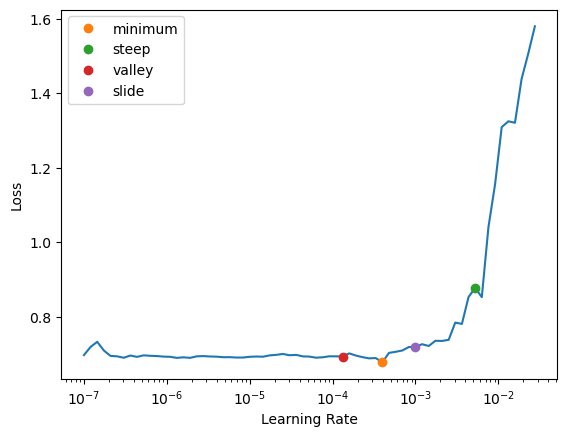

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.683440,0.677744,0.550000,00:23
1,0.273164,0.286426,0.875000,00:23
2,0.224753,0.286356,0.865000,00:23


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.22475342452526093
valid_loss 0.28635576367378235
accuracy 0.8650000095367432


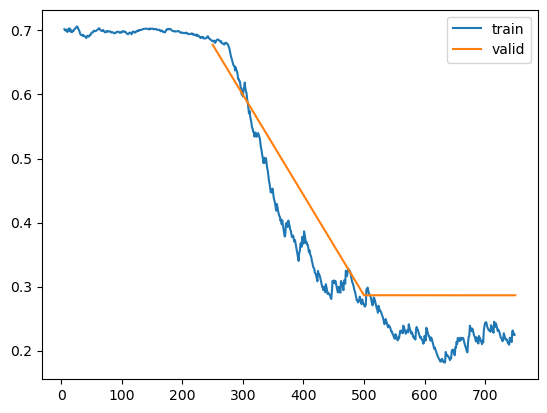

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.export("../models/test.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(civil_labels)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `torch.utils.data.Dataset`s

In [ ]:
print("Train|Validation examples: ", len(civil_train_ds), len(civil_valid_ds))

print(civil_train_ds[:2])
print("")
print(civil_train_ds["text"][:2])

Train|Validation examples:  1000 200
{'text': ['I don’t think you’ve been asked to commit a sin of the flesh, simply to make sense.\n\nI would tend to agree that as to your posts I disagree more often than like, but that is a function of what you post rather than any predisposition on my part.\n\nMy mission is to engage in Catholic conversation. If you find that disrupts what you do, the conclusion is rather obvious.', 'So why will no NFL teams hire Kaepernick?'], 'toxicity': [0, 0], 'severe_toxicity': [0, 0], 'obscene': [0, 0], 'threat': [0, 0], 'insult': [0, 0], 'identity_attack': [0, 0], 'sexual_explicit': [0, 0], 'is_valid': [False, False]}

['I don’t think you’ve been asked to commit a sin of the flesh, simply to make sense.\n\nI would tend to agree that as to your posts I disagree more often than like, but that is a function of what you post rather than any predisposition on my part.\n\nMy mission is to engage in Catholic conversation. If you find that disrupts what you do, the c

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_civil_train_ds = civil_train_ds.map(tokenize_func, batched=True)
proc_civil_train_ds.set_format("torch", columns=hf_tokenizer.model_input_names + civil_labels)

proc_civil_valid_ds = civil_valid_ds.map(tokenize_func, batched=True)
proc_civil_valid_ds.set_format("torch", columns=hf_tokenizer.model_input_names + civil_labels)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
# define our PyTorch Dataset class
class HFTextMultilabelClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, hf_tokenizer, labels):
        self.hf_dataset = hf_dataset
        self.hf_tokenizer = hf_tokenizer
        self.labels = labels

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        item["label"] = [item[lbl] for lbl in self.labels]
        return item


# build our PyTorch training and validation Datasets
pt_proc_civil_train_ds = HFTextMultilabelClassificationDataset(proc_civil_train_ds, hf_tokenizer=hf_tokenizer, labels=civil_labels)
pt_proc_civil_valid_ds = HFTextMultilabelClassificationDataset(proc_civil_valid_ds, hf_tokenizer=hf_tokenizer, labels=civil_labels)

##### Step 3: `DataLoaders`

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(pt_proc_civil_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(pt_proc_civil_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

In [ ]:
print(len(train_dl), len(valid_dl))

b = next(iter(train_dl))
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0][:200]))
print("")
print(b[1])

# b

250 25
2

[CLS] Actually, that is not what the statement says. "The Weld Central TEAM did not display the Confederate flag" but the joint statement goes on to admit that Weld FANS may, or may not, have attempted to bring the flag in and that there is insufficient evidence to say one way or another definitively. The original Manuel statement blurred this distinction. So, the headline is -- literally -- the fake news in that it implies a factual reality out of context. As this editorial notes, it is difficult to police what fans but not the team does at these events. What is appalling is the insistence on both schools to portray themselves as the sole victims of this incident.[SEP]

tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]])


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# dls.show_batch(dataloaders=dls, max_n=2, trunc_at=800)

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# learn.dls.valid.show_batch()

In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'one_batch'
# learn.summary()

##### Step 5: Train

SuggestedLRs(minimum=0.00043651582673192023, steep=0.0003311311302240938, valley=0.00010964782268274575, slide=0.0008317637839354575)

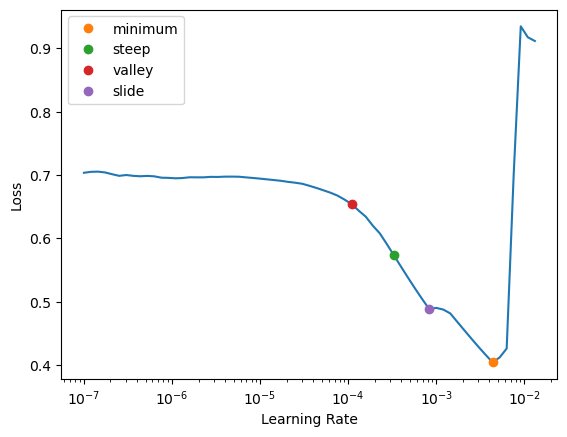

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.149558,0.067691,0.984286,00:15
1,0.073681,0.067030,0.984286,00:16
2,0.075441,0.066153,0.984286,00:15


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.07544081658124924
valid_loss 0.06615324318408966
accuracy_multi 0.9842857122421265


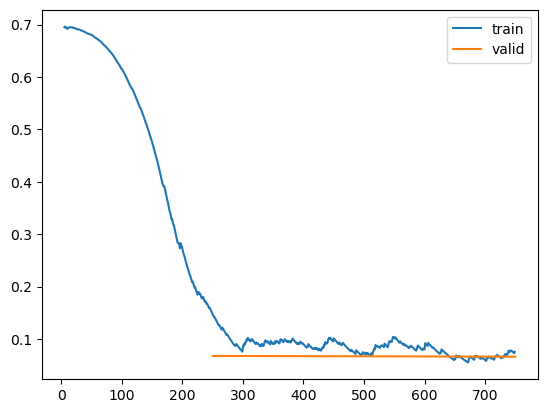

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.export("../models/test.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

### Hugging Face

#### Multiclass

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(labels)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Datasets`

We'll use the Hugging Face `Dataset` objects created in *Setup*, but these could just as well be instances of `torch.utils.data.Dataset`

In [ ]:
print("Train|Validation examples: ", len(train_ds), len(valid_ds))

print(train_ds[:2])
print("")
print(train_ds["text"][:2])

Train|Validation examples:  1000 200
{'text': ['Being a music student myself, I thought a movie taking place in a conservatory might be fun to watch. Little did I know... (I had no idea this movie was based on a book by Britney Spears) This movie was implausible throughout. It\'s obvious that whoever wrote the script never set foot in a conservatory and doesn\'t know a thing about classical music. Let me give you just a few examples: 1) There is NO WAY anyone would be admitted to a classical conservatory with no classical training whatsoever! Just having a nice pop voice isn\'t enough, besides, that\'s a different thing altogether - another genre, different technique. It\'s like playing the violin when applying for a viola class. 2) How come the lady teaching music theory was in the singing jury? If she wasn\'t a singing professor herself, she would have no say in a situation like that, and if she was a singing professor, why weren\'t we told so? 3) Being able to read music is a necess

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_train_ds = train_ds.map(tokenize_func, batched=True)
proc_train_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

proc_valid_ds = valid_ds.map(tokenize_func, batched=True)
proc_valid_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

print(proc_train_ds)
print(proc_valid_ds)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-ea4b1ec8a6a4700a.arrow


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'is_valid', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})
Dataset({
    features: ['text', 'label', 'is_valid', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 200
})


##### Step 3: `DataLoaders`

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(proc_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(proc_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

In [ ]:
print(len(train_dl), len(valid_dl))

b = next(iter(train_dl))
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0][:200]))
print("")
print(b[1])

# b

250 25
2

[CLS] Joan Fontaine is "A Damsel in Distress" in this 1937 musical starring Fred Astaire, George Burns, and Gracie Allen. The plot, what there is of it, is about a British woman (Fontaine) in love with an American, who is mistaken for Astaire, a musical comedy star.<br /><br />The film, directed by George Stevens, contains some wonderful Gershwin music, including "Nice Work if You Can Get It" and "A Foggy Day." The best scene is the "Stiff Upper Lip" number, which takes place in a fun house.<br /><br />Astaire's singing voice sounds more robust in this film than it does in others, and he has a couple of excellent dance numbers. Burns plays his over the top publicist and Allen is Burns' secretary. She's hilarious. The problem, as others have pointed out, is Fontaine, who has to dance with Astaire at the end of the film

tensor([1, 0, 0, 1])


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=PreCalculatedCrossEntropyLoss(),  # CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# learn.dls.valid.show_batch()

In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'one_batch'
# learn.summary()

##### Step 5: Train

SuggestedLRs(minimum=3.981071640737355e-05, steep=0.013182567432522774, valley=7.585775892948732e-05, slide=0.0010000000474974513)

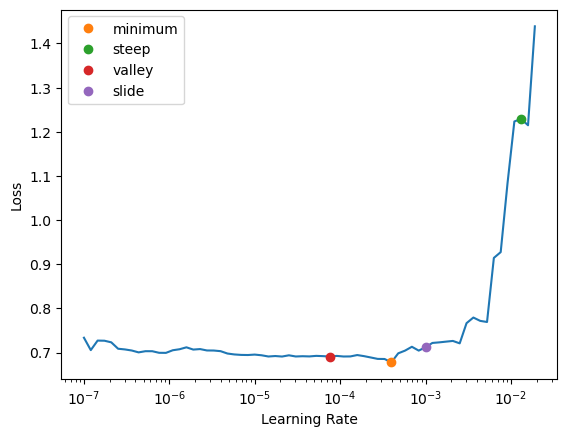

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.664521,0.599523,0.680000,00:28
1,0.250017,0.288197,0.885000,00:23
2,0.186465,0.291984,0.880000,00:23


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.18646495044231415
valid_loss 0.2919836938381195
accuracy 0.8799999952316284


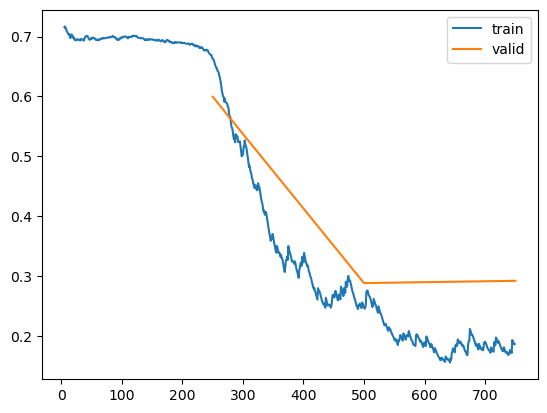

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.export("../models/test_topic_segmentation.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(civil_labels)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Datasets`

We'll use the Hugging Face `Dataset` objects created in *Setup*, but these could just as well be instances of `torch.utils.data.Dataset`

In [ ]:
print("Train|Validation examples: ", len(civil_train_ds), len(civil_valid_ds))

print(civil_train_ds[:2])
print("")
print(civil_train_ds["text"][:2])

Train|Validation examples:  1000 200
{'text': ['I don’t think you’ve been asked to commit a sin of the flesh, simply to make sense.\n\nI would tend to agree that as to your posts I disagree more often than like, but that is a function of what you post rather than any predisposition on my part.\n\nMy mission is to engage in Catholic conversation. If you find that disrupts what you do, the conclusion is rather obvious.', 'So why will no NFL teams hire Kaepernick?'], 'toxicity': [0, 0], 'severe_toxicity': [0, 0], 'obscene': [0, 0], 'threat': [0, 0], 'insult': [0, 0], 'identity_attack': [0, 0], 'sexual_explicit': [0, 0], 'is_valid': [False, False]}

['I don’t think you’ve been asked to commit a sin of the flesh, simply to make sense.\n\nI would tend to agree that as to your posts I disagree more often than like, but that is a function of what you post rather than any predisposition on my part.\n\nMy mission is to engage in Catholic conversation. If you find that disrupts what you do, the c

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    updated_example = dict(hf_tokenizer(example["text"], truncation=True))
    labels = torch.stack([tensor(example[lbl]) for lbl in civil_labels], dim=-1)
    updated_example["label"] = labels

    return updated_example


proc_civil_train_ds = civil_train_ds.map(tokenize_func, batched=True)
# proc_civil_train_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

proc_civil_valid_ds = civil_valid_ds.map(tokenize_func, batched=True, batch_size=4)
# proc_civil_valid_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

print(proc_civil_train_ds)
print(proc_civil_valid_ds)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit', 'is_valid', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 1000
})
Dataset({
    features: ['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit', 'is_valid', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 200
})


##### Step 3: `DataLoaders`

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(proc_civil_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(proc_civil_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

In [ ]:
print(len(train_dl), len(valid_dl))

b = next(iter(train_dl))
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0][:200]))
print("")
print(b[1])

# b

250 25
2

[CLS] Actually, that is not what the statement says. "The Weld Central TEAM did not display the Confederate flag" but the joint statement goes on to admit that Weld FANS may, or may not, have attempted to bring the flag in and that there is insufficient evidence to say one way or another definitively. The original Manuel statement blurred this distinction. So, the headline is -- literally -- the fake news in that it implies a factual reality out of context. As this editorial notes, it is difficult to police what fans but not the team does at these events. What is appalling is the insistence on both schools to portray themselves as the sole victims of this incident.[SEP]

tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]])


In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# dls.show_batch(dataloaders=dls, max_n=2, trunc_at=800)

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# learn.dls.valid.show_batch()

In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'one_batch'
# learn.summary()

##### Step 5: Train

SuggestedLRs(minimum=0.00043651582673192023, steep=0.0003311311302240938, valley=0.00010964782268274575, slide=0.0008317637839354575)

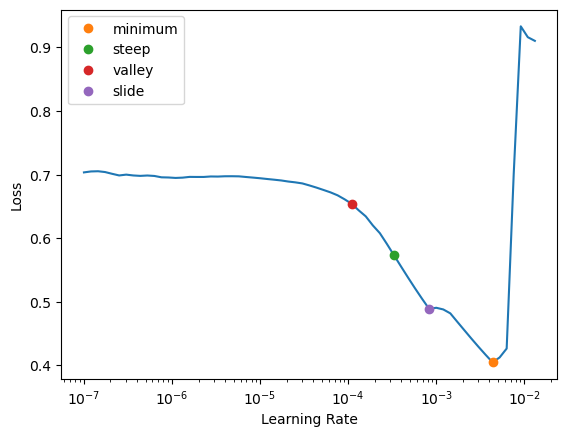

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.149558,0.067688,0.984286,00:17
1,0.073680,0.067030,0.984286,00:17
2,0.075438,0.066149,0.984286,00:12


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.07543810456991196
valid_loss 0.06614942103624344
accuracy_multi 0.9842857122421265


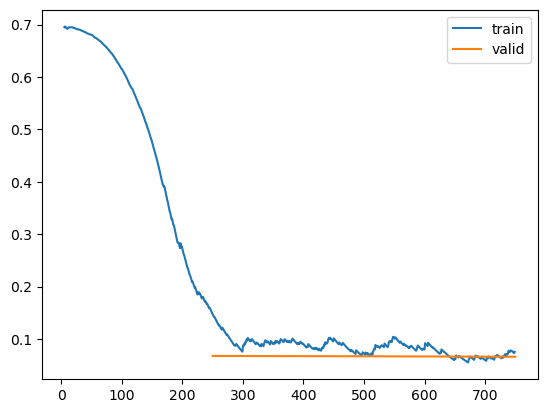

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.export("../models/test_topic_segmentation.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

## Low-Level API: Data

This section demonstrates how you can migrate from using PyTorch/Hugging Face to fast.ai `Datasets` and `DataLoaders` to recapture much of the fast.ai specific features unavailable when using basic PyTorch.

### `TextInput` -

In [ ]:
# |export
class TextInput(TensorBase):
    """The base represenation of your inputs; used by the various fastai `show` methods"""

    pass

A `TextInput` object is returned from the decodes method of `BatchDecodeTransform` as a means to customize `@typedispatch`ed functions like `DataLoaders.show_batch` and `Learner.show_results`. The value will the your "input_ids".

### `BatchDecodeTransform` -

In [ ]:
# |export
class BatchDecodeTransform(Transform):
    """A class used to cast your inputs as `input_return_type` for fastai `show` methods"""

    def __init__(
        self,
        # A Hugging Face tokenizer (not required if passing in an instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_tokenizer: PreTrainedTokenizerBase,
        # The abbreviation/name of your Hugging Face transformer architecture (not required if passing in an instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_arch: str = None,
        # A Hugging Face configuration object (not required if passing in an instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_config: PretrainedConfig = None,
        # A Hugging Face model (not required if passing in an instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_model: PreTrainedModel = None,
        # Used by typedispatched show methods
        input_return_type: type = TextInput,
        # Any other keyword arguments
        **kwargs,
    ):
        store_attr()
        self.kwargs = kwargs

    def decodes(self, items: dict):
        """Returns the proper object and data for show related fastai methods"""
        return self.input_return_type(items["input_ids"])

        # inps = self.input_return_type(items[0]["input_ids"])
        # # inps = self.input_return_type(items[0][0])
        # if len(items) > 1:
        #     return inps, *items[1:]
        # else:
        #     labels = items[0].get("labels", [None] * items[0]["input_ids"])
        #     return inps, labels

As of fastai 2.1.5, before batch transforms no longer have a `decodes` method ... and so, I've introduced a standard batch transform here, `BatchDecodeTransform`, (one that occurs "after" the batch has been created) that will do the decoding for us.

### Utility classes and methods 

These methods are use internally for getting blurr transforms associated to your `DataLoaders`

In [ ]:
# |export
def get_blurr_tfm(
    # A list of transforms (e.g., dls.after_batch, dls.before_batch, etc...)
    tfms_list: Pipeline,
    # The transform to find
    tfm_class: Transform = BatchDecodeTransform,
):
    """
    Given a fastai DataLoaders batch transforms, this method can be used to get at a transform
    instance used in your Blurr DataBlock
    """
    return next(filter(lambda el: issubclass(type(el), tfm_class), tfms_list), None)

In [ ]:
nbdev.show_doc(get_blurr_tfm, title_level=3)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/core.py#L259){target="_blank" style="float:right; font-size:smaller"}

### get_blurr_tfm

>      get_blurr_tfm (tfms_list:fastcore.transform.Pipeline,
>                     tfm_class:fastcore.transform.Transform=<class
>                     '__main__.BatchDecodeTransform'>)

Given a fastai DataLoaders batch transforms, this method can be used to get at a transform
instance used in your Blurr DataBlock

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| tfms_list | Pipeline |  | A list of transforms (e.g., dls.after_batch, dls.before_batch, etc...) |
| tfm_class | Transform | BatchDecodeTransform | The transform to find |

In [ ]:
# |export
def first_blurr_tfm(
    # Your fast.ai `DataLoaders
    dls: DataLoaders,
    # The Blurr transforms to look for in order
    tfms: list[Transform] = [BatchDecodeTransform],
):
    """
    This convenience method will find the first Blurr transform required for methods such as
    `show_batch` and `show_results`. The returned transform should have everything you need to properly
    decode and 'show' your Hugging Face inputs/targets
    """
    for tfm in tfms:
        found_tfm = get_blurr_tfm(dls.before_batch, tfm_class=tfm)
        if found_tfm:
            return found_tfm

        found_tfm = get_blurr_tfm(dls.after_batch, tfm_class=tfm)
        if found_tfm:
            return found_tfm

In [ ]:
nbdev.show_doc(first_blurr_tfm, title_level=3)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/core.py#L272){target="_blank" style="float:right; font-size:smaller"}

### first_blurr_tfm

>      first_blurr_tfm (dls:fastai.data.core.DataLoaders,
>                       tfms:list[fastcore.transform.Transform]=[<class
>                       '__main__.BatchDecodeTransform'>])

This convenience method will find the first Blurr transform required for methods such as
`show_batch` and `show_results`. The returned transform should have everything you need to properly
decode and 'show' your Hugging Face inputs/targets

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| dls | DataLoaders |  | Your fast.ai `DataLoaders |
| tfms | list[Transform] | [<class '__main__.BatchDecodeTransform'>] | The Blurr transforms to look for in order |

### `show_batch` -

In [ ]:
# |export
@typedispatch
def show_batch(
    # This typedispatched `show_batch` will be called for `TextInput` typed inputs
    x: TextInput,
    # Your targets
    y,
    # Your raw inputs/targets
    samples,
    # Your `DataLoaders`. This is required so as to get at the Hugging Face objects for
    # decoding them into something understandable
    dataloaders,
    # Your `show_batch` context
    ctxs=None,
    # The maximum number of items to show
    max_n=6,
    # Any truncation your want applied to your decoded inputs
    trunc_at=None,
    # Any other keyword arguments you want applied to `show_batch`
    **kwargs,
):
    # grab our tokenizer
    tfm = first_blurr_tfm(dataloaders)
    hf_tokenizer = tfm.hf_tokenizer

    # if we've included our labels list, we'll use it to look up the value of our target(s)
    trg_labels = tfm.kwargs["labels"] if ("labels" in tfm.kwargs) else None

    res = L()
    n_inp = dataloaders.n_inp

    n_samples = min(max_n, dataloaders.bs)
    for idx in range(n_samples):
        input_ids = x[idx]
        label = y[idx] if y is not None else None
        sample = samples[idx] if samples is not None else None

        rets = [hf_tokenizer.decode(input_ids, skip_special_tokens=True)[:trunc_at]]
        for item in sample[n_inp:]:
            if not torch.is_tensor(item):
                trg = trg_labels[int(item)] if trg_labels else item
            elif is_listy(item.tolist()):
                trg = [trg_labels[idx] for idx, val in enumerate(label.numpy().tolist()) if (val == 1)] if (trg_labels) else label.numpy()
            else:
                trg = trg_labels[label.item()] if (trg_labels) else label.item()

            rets.append(trg)
        res.append(tuplify(rets))

    cols = ["text"] + ["target" if (i == 0) else f"target_{i}" for i in range(len(res[0]) - n_inp)]
    display_df(pd.DataFrame(res, columns=cols)[:max_n])
    return ctxs

### `TextDataLoader` -

In [ ]:
# |export
@delegates()
class TextDataLoader(TfmdDL):
    """
    A transformed `DataLoader` that works with Blurr.
    From the fastai docs: A `TfmDL` is described as "a DataLoader that creates Pipeline from a list of Transforms
    for the callbacks `after_item`, `before_batch` and `after_batch`. As a result, it can decode or show a processed batch.
    """

    def __init__(
        self,
        # A standard PyTorch Dataset
        dataset: torch.utils.data.dataset.Dataset | Datasets,
        # A Hugging Face tokenizer (not required if passing in an instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_tokenizer: PreTrainedTokenizerBase,
        # The abbreviation/name of your Hugging Face transformer architecture (not required if passing in an \
        # instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_arch: str = None,
        # A Hugging Face configuration object (not required if passing in an  \
        # instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_config: PretrainedConfig = None,
        # A Hugging Face model (not required if passing in an instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_model: PreTrainedModel = None,
        # An instance of `TextCollatorWithPadding` or equivalent (defaults to `BlurrBatchCreator`)
        text_collator: TextCollatorWithPadding = None,
        # The batch_tfm used to decode Blurr batches (defaults to `BatchDecodeTransform`)
        batch_decode_tfm: BatchDecodeTransform = None,
        # Used by typedispatched show methods
        input_return_type: type = TextInput,
        # Keyword arguments to be applied to your `batch_decode_tfm`
        batch_decode_kwargs: dict = {},
        # Keyword arguments to be applied to `BlurrDataLoader`
        **kwargs,
    ):
        # define what happens when a batch is created (e.g., this is where collation happens)
        if "create_batch" in kwargs:
            kwargs.pop("create_batch")
        if not text_collator:
            text_collator = TextCollatorWithPadding(hf_tokenizer, hf_arch, hf_config, hf_model)

        # define the transform applied after the batch is created (used of show methods)
        if "after_batch" in kwargs:
            kwargs.pop("after_batch")
        if not batch_decode_tfm:
            batch_decode_tfm = BatchDecodeTransform(
                hf_tokenizer,
                hf_arch,
                hf_config,
                hf_model,
                input_return_type,
                **batch_decode_kwargs.copy(),
            )

        super().__init__(
            dataset=dataset,
            create_batch=text_collator,
            after_batch=batch_decode_tfm,
            **kwargs,
        )
        store_attr()

    def new(
        self,
        # A standard PyTorch and fastai dataset
        dataset: Union[torch.utils.data.dataset.Dataset, Datasets] = None,
        # The class you want to create an instance of (will be "self" if None)
        cls: type = None,
        #  Any additional keyword arguments you want to pass to the __init__ method of `cls`
        **kwargs,
    ):
        """
        We have to override the new method in order to add back the Hugging Face objects in this factory
        method (called for example in places like `show_results`). With the exception of the additions to the kwargs
        dictionary, the code below is pulled from the `DataLoaders.new` method as is.
        """
        # we need to add these arguments back in (these, after_batch, and create_batch will go in as kwargs)
        kwargs["hf_arch"] = self.hf_arch
        kwargs["hf_config"] = self.hf_config
        kwargs["hf_tokenizer"] = self.hf_tokenizer
        kwargs["hf_model"] = self.hf_model

        kwargs["text_collator"] = self.text_collator
        kwargs["batch_decode_tfm"] = self.batch_decode_tfm
        kwargs["batch_decode_kwargs"] = self.batch_decode_kwargs

        return super().new(dataset, cls, **kwargs)

### `sorted_dl_func` -

In [ ]:
# |export
def sorted_dl_func(
    example,
    # A Hugging Face tokenizer
    hf_tokenizer: PreTrainedTokenizerBase,
    # The `is_split_into_words` argument applied to your `hf_tokenizer` during tokenization. \
    # Set this to 'True' if your inputs are pre-tokenized (not numericalized)
    is_split_into_words: bool = False,
    # Any other keyword arguments you want to include during tokenization
    tok_kwargs: dict = {},
):
    """This method is used by the `SortedDL` to ensure your dataset is sorted *after* tokenization"""
    txt = None
    if isinstance(example[0], dict):
        if "input_ids" in example[0]:
            # if inputs are pretokenized
            return len(example[0]["input_ids"])
        else:
            txt = example[0]["text"]
    else:
        txt = example[0]

    return len(txt) if is_split_into_words else len(hf_tokenizer.tokenize(txt, **tok_kwargs))

In [ ]:
nbdev.show_doc(sorted_dl_func, title_level=3)

---

### sorted_dl_func

>      sorted_dl_func (example, hf_tokenizer:transformers.tokenization_utils_bas
>                      e.PreTrainedTokenizerBase,
>                      is_split_into_words:bool=False, tok_kwargs:dict={})

This method is used by the `SortedDL` to ensure your dataset is sorted *after* tokenization

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| example |  |  |  |
| hf_tokenizer | PreTrainedTokenizerBase |  | A Hugging Face tokenizer |
| is_split_into_words | bool | False | The `is_split_into_words` argument applied to your `hf_tokenizer` during tokenization. \<br>Set this to 'True' if your inputs are pre-tokenized (not numericalized) |
| tok_kwargs | dict | {} | Any other keyword arguments you want to include during tokenization |

## Low-Level API: Training

In this section, we include a custom `show_results()` method that will work with fast.ai's low-level and mid-level (think `DataBlock`) APIs.

### `show_results` -

In [ ]:
# |export
@typedispatch
def show_results(
    # This typedispatched `show_results` will be called for `TextInput` typed inputs
    x: TextInput,
    # Your targets
    y,
    # Your raw inputs/targets
    samples,
    # The model's predictions
    outs,
    # Your `Learner`. This is required so as to get at the Hugging Face objects for decoding them into
    # something understandable
    learner,
    # Your `show_results` context
    ctxs=None,
    # The maximum number of items to show
    max_n=6,
    # Any truncation your want applied to your decoded inputs
    trunc_at=None,
    # Any other keyword arguments you want applied to `show_results`
    **kwargs,
):
    # grab our tokenizer
    tfm = first_blurr_tfm(learner.dls)
    hf_tokenizer = tfm.hf_tokenizer

    # if we've included our labels list, we'll use it to look up the value of our target(s)
    trg_labels = tfm.kwargs["labels"] if ("labels" in tfm.kwargs) else None

    res = L()
    n_inp = learner.dls.n_inp

    n_samples = min(max_n, learner.dls.bs)
    for idx in range(n_samples):
        input_ids = x[idx]
        label = y[idx] if y is not None else None
        pred = outs[idx]
        sample = samples[idx] if samples is not None else None
        # add in the input text
        rets = [hf_tokenizer.decode(input_ids, skip_special_tokens=True)[:trunc_at]]
        # add in the targets
        for item in sample[n_inp:]:
            if not torch.is_tensor(item):
                trg = trg_labels[int(item)] if trg_labels else item
            elif is_listy(item.tolist()):
                trg = [trg_labels[idx] for idx, val in enumerate(label.numpy().tolist()) if (val == 1)] if (trg_labels) else label.numpy()
            else:
                trg = trg_labels[label.item()] if (trg_labels) else label.item()

            rets.append(trg)
        # add in the predictions
        for item in pred:
            if not torch.is_tensor(item):
                p = trg_labels[int(item)] if trg_labels else item
            elif is_listy(item.tolist()):
                p = [trg_labels[idx] for idx, val in enumerate(label.numpy().tolist()) if (val == 1)] if (trg_labels) else label.numpy()
            else:
                p = trg_labels[label.item()] if (trg_labels) else label.item()

            rets.append(p)

        res.append(tuplify(rets))

    cols = ["text"] + ["target" if (i == 0) else f"target_{i}" for i in range(len(res[0]) - n_inp * 2)]
    cols += ["prediction" if (i == 0) else f"prediction_{i}" for i in range(len(res[0]) - n_inp * 2)]
    display_df(pd.DataFrame(res, columns=cols)[:max_n])
    return ctxs

## Low-Level API: Examples

### Using fast.ai `Datasets` and `DataLoaders`

#### Multiclass

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(labels)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Datasets`

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_imdb_ds = imdb_ds.map(tokenize_func, batched=True)
proc_imdb_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

# turn Arrow into DataFrame (`ColSplitter` only works with `DataFrame`s)
train_df = pd.DataFrame(proc_imdb_ds)
train_df.head()

# define dataset splitter
splitter = ColSplitter("is_valid")
splits = splitter(imdb_df)


# define how we want to build our inputs and targets
def _build_inputs(example):
    return {fwd_arg_name: example[fwd_arg_name] for fwd_arg_name in hf_tokenizer.model_input_names if fwd_arg_name in list(example.keys())}


def _build_targets(example):
    return example["label"]


# create our fastai `Datasets` object
dsets = Datasets(items=train_df, splits=splits, tfms=[[_build_inputs], _build_targets], n_inp=1)

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

In [ ]:
print("Items in train|validation datasets: ", len(dsets.train), len(dsets.valid))

example = dsets.valid[0]
# example

print(f"Items in each example: {len(example)}")
print(f"Example inputs: {list(example[0].keys())}")
print(f"Example target(s): {example[1]}")

Items in train|validation datasets:  1000 200
Items in each example: 2
Example inputs: ['input_ids', 'token_type_ids', 'attention_mask']
Example target(s): 1


##### Step 3: `DataLoaders`

In [ ]:
data_collator = TextCollatorWithPadding(hf_tokenizer)
sort_func = partial(sorted_dl_func, hf_tokenizer=hf_tokenizer)

dls = dsets.dataloaders(
    batch_size=4,
    create_batch=data_collator,
    dl_type=partial(SortedDL, sort_func=sort_func),
)

In [ ]:
print(len(dls.train), len(dls.valid))

b = dls.valid.one_batch()
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0][:200]))
print("")
print(b[1])

250 50
2

[CLS] Just got this in the mail and I was positively surprised. As a big fan of 70's cinema it doesn't take much to satisfy me when it comes to these kind of flicks. Despite the obvious low budget on this movie, the acting is overall good and you can already see why Pesci was to become on of the greatest actors ever. I'm not sure how authentic this movie is, but it sure is a good contribution to the mob genre.....[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]

tensor([1, 0, 0, 0], device='cuda:0')


In [ ]:
# NOPE: Won't work with fastai Datasets/DataLoaders without transforms
# RecursionError: maximum recursion depth exceeded while calling a Python object
# dls.show_batch(dataloaders=dls, max_n=2, trunc_at=800)

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with fastai Datasets/DataLoaders without transforms
# RecursionError: maximum recursion depth exceeded while calling a Python object
# learn.dls.valid.show_batch()

In [ ]:
# YES: Since we're using fastai `DataLoaders`, we get `one_batch()` back
learn.summary()

BaseModelWrapper (Input shape: 4 x 1332)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 1332 x 768      
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 1332 x 3072     
Linear                        

##### Step 5: Train

SuggestedLRs(minimum=6.309573450380412e-08, steep=0.005248074419796467, valley=5.248074739938602e-05, slide=0.0002754228771664202)

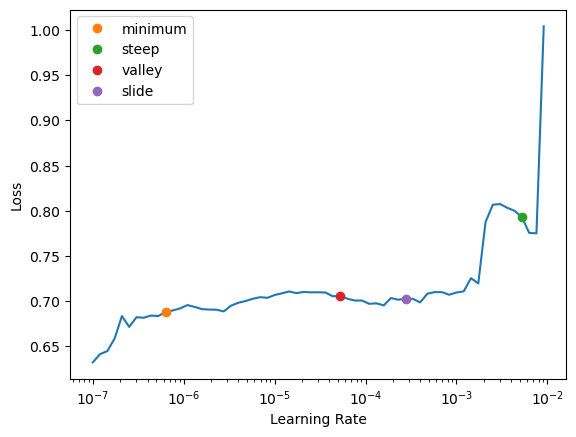

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.679256,0.632566,0.600000,00:19
1,0.246384,0.256450,0.895000,00:20
2,0.180521,0.270838,0.900000,00:20


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.18052071332931519
valid_loss 0.27083829045295715
accuracy 0.8999999761581421


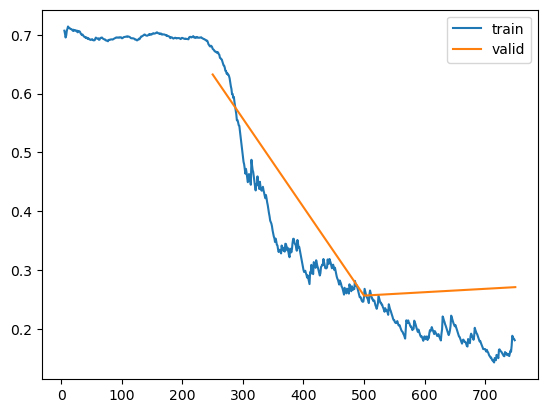

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with fastai Datasets/DataLoaders without transforms
# RecursionError: maximum recursion depth exceeded in __instancecheck__
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`
# AttributeError: 'DataLoader' object has no attribute 'new'
learn.export("../models/test_text_core_low_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(civil_labels)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Datasets`

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    updated_example = dict(hf_tokenizer(example["text"], truncation=True))
    labels = torch.stack([tensor(example[lbl]) for lbl in civil_labels], dim=-1)
    updated_example["label"] = labels

    return updated_example


proc_civil_ds = civil_ds.map(tokenize_func, batched=True)
proc_civil_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

# turn Arrow into DataFrame (`ColSplitter` only works with `DataFrame`s)
train_df = pd.DataFrame(proc_civil_ds)
train_df.head()

# define dataset splitter
splitter = ColSplitter("is_valid")
splits = splitter(civil_df)


# define how we want to build our inputs and targets
def _build_inputs(example):
    return {fwd_arg_name: example[fwd_arg_name] for fwd_arg_name in hf_tokenizer.model_input_names if fwd_arg_name in list(example.keys())}


def _build_targets(example):
    return example["label"]


# create our fastai `Datasets` object
dsets = Datasets(items=train_df, splits=splits, tfms=[[_build_inputs], _build_targets], n_inp=1)

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

In [ ]:
print("Items in train|validation datasets: ", len(dsets.train), len(dsets.valid))

example = dsets.valid[0]
# example

print(f"Items in each example: {len(example)}")
print(f"Example inputs: {list(example[0].keys())}")
print(f"Example target(s): {example[1]}")

Items in train|validation datasets:  1000 200
Items in each example: 2
Example inputs: ['input_ids', 'token_type_ids', 'attention_mask']
Example target(s): tensor([0, 0, 0, 0, 0, 0, 0])


##### Step 3: `DataLoaders`

In [ ]:
data_collator = TextCollatorWithPadding(hf_tokenizer)
sort_func = partial(sorted_dl_func, hf_tokenizer=hf_tokenizer)
dls = dsets.dataloaders(
    batch_size=4,
    create_batch=data_collator,
    dl_type=partial(SortedDL, sort_func=sort_func),
)

TypeError: 'DebertaV2TokenizerFast' object is not subscriptable

In [ ]:
print(len(dls.train), len(dls.valid))

b = dls.valid.one_batch()
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0][:200]))
print("")
print(b[1])

250 50
2

[CLS] All true, sirencall, no matter what side one is on. Well said. But hold up, how can Trump be ignorant of history? Didn't the American people elect him? Doesn't that automatically make him retroactively brilliant on all issues, even those he never cared about or read up on? Isn't that how it works? All magic like.[SEP]

tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]], device='cuda:0')


In [ ]:
# NOPE: Won't work with fastai Datasets/DataLoaders without transforms
# RecursionError: maximum recursion depth exceeded while calling a Python object
# dls.show_batch(dataloaders=dls, max_n=2, trunc_at=800)

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with fastai Datasets/DataLoaders without transforms
# RecursionError: maximum recursion depth exceeded while calling a Python object
# learn.dls.valid.show_batch()

In [ ]:
# YES: Since we're using fastai `DataLoaders`, we get `one_batch()` back
learn.summary()

BaseModelWrapper (Input shape: 4 x 263)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 263 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 263 x 3072      
Linear                         

##### Step 5: Train

SuggestedLRs(minimum=0.0005248074419796466, steep=0.0002754228771664202, valley=6.30957365501672e-05, slide=0.0010000000474974513)

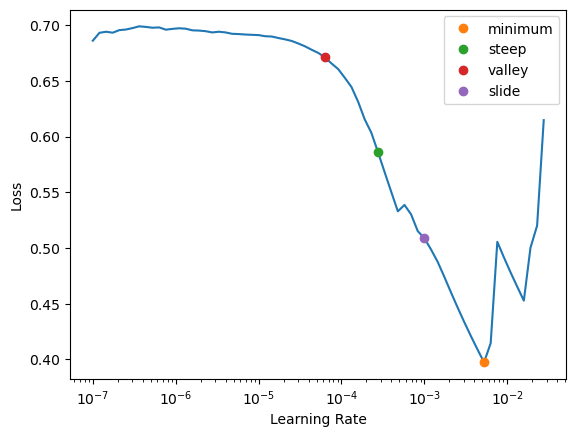

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.143963,0.069607,0.984286,00:18
1,0.070092,0.064973,0.984286,00:17
2,0.080973,0.064396,0.984286,00:23


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.08097293227910995
valid_loss 0.06439550220966339
accuracy_multi 0.9842856526374817


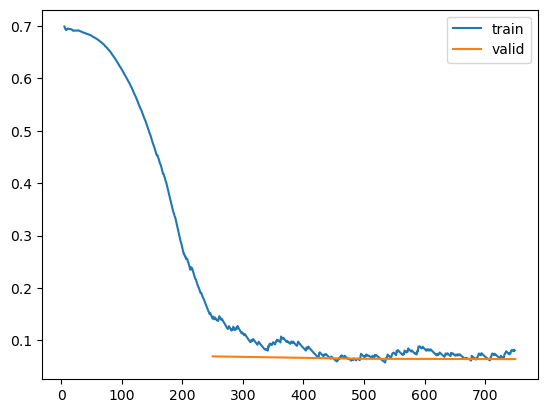

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with fastai Datasets/DataLoaders without transforms
# RecursionError: maximum recursion depth exceeded in __instancecheck__
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`
# AttributeError: 'DataLoader' object has no attribute 'new'
learn.export("../models/test_text_core_low_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

### Using `BatchDecodeTransform` and `TextDataLoader`

#### Multiclass

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(labels)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Dataset`s

We'll use the Hugging Face `Dataset` objects created in *Setup*, but these could just as well be instances of `torch.utils.data.Dataset`

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_imdb_ds = imdb_ds.map(tokenize_func, batched=True)
# proc_imdb_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])


# define dataset splitter
def _split_func(example):
    return example["is_valid"] == True


splitter = FuncSplitter(_split_func)
splits = splitter(proc_imdb_ds)


# define how we want to build our inputs and targets
def _build_inputs(example):
    return {fwd_arg_name: example[fwd_arg_name] for fwd_arg_name in hf_tokenizer.model_input_names if fwd_arg_name in list(example.keys())}


def _build_targets(example):
    return example["label"]


# create our fastai `Datasets` object
dsets = Datasets(items=proc_imdb_ds, splits=splits, tfms=[[_build_inputs], _build_targets], n_inp=1)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-ecb38dbbbc9d9f36.arrow


##### Step 3: `DataLoaders`

In [ ]:
label_names = train_ds.features["label"].names
label_names

['neg', 'pos']

In [ ]:
batch_size = 4

trn_dl = TextDataLoader(
    dsets.train,
    hf_tokenizer,
    batch_decode_kwargs={"labels": label_names},
    shuffle=True,
    batch_size=batch_size,
)

val_dl = TextDataLoader(
    dsets.valid,
    hf_tokenizer,
    batch_decode_kwargs={"labels": label_names},
    batch_size=batch_size * 2,
)

dls = DataLoaders(trn_dl, val_dl)

In [ ]:
print(len(dls.train), len(dls.valid))

b = dls.valid.one_batch()
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0][:200]))
print("")
print(b[1])

250 25
2

[CLS] Just got this in the mail and I was positively surprised. As a big fan of 70's cinema it doesn't take much to satisfy me when it comes to these kind of flicks. Despite the obvious low budget on this movie, the acting is overall good and you can already see why Pesci was to become on of the greatest actors ever. I'm not sure how authentic this movie is, but it sure is a good contribution to the mob genre.....[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]

tensor([1, 0, 0, 0, 1, 1, 0, 0])


In [ ]:
# YES: Since we're using fastai `TfmDL` and including a transform that knows how to show our inputs,
# we get `show_results()` back
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=800)

,text,target
0,"Can I Do it 'till I Need Glasses? at the very least proves the point that anyone can make a movie. Talent is not a consideration. The folks who unleashed this wretched pile of spewing vomit upon the world, lack any semblance of talent, taste or intelligence. The target audience must consist of the recently labotimized, and infants who play with their own feces. Anyone else would be far too world wise to get even a snicker out of this film. It consists of a series of sophmoric skits in which the punchline does not even extend to the obvious. It ends at the ludicrous. The jokes told are the types of jokes that elementary school children tell (usually potty or sexually related) where they don't know the meaning of all of the terms they use. You know, like the one about daddy's car and mommy's",neg
1,"Yes, Kazaam is one of those horribly bad movies that almost reminds one of everything that is wrong with not just kids movies, but with humanity. Here we have Shaq as a rapping genie- yes, a RAPPING genie- where he does everything from making bad puns to dressing in ridiculous outfits, all ending in him in a Christ-like pose with lots of light surrounding him. So, yeah, expect really cheesy bits, including the first wish being a lot of junk food falling down from the sky (and, regrettably, not knocking out the two main characters, particularly the kid). What might not be expected is that a film with a kid and Shaquille O'Neill would be so incredibly schmaltzy! The main plot of the film involves this kid, played in that all-too-typical and annoying-kid fashion by the great-grandson of Frank",neg


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# YES: Since we're using fastai `TfmDL` and including a transform that knows how to show our inputs,
# we get `show_batch()` back
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,"Just got this in the mail and I was positively surprised. As a big fan of 70's cinema it doesn't take much to satisfy me when it comes to these kind of flicks. Despite the obvious low budget on this movie, the acting is overall good and you can alrea",pos
1,"Boy Oh Boy, does this movie stink. This movie is one of the worst pieces of trash I have ever seen in my whole entire life. Please, even if your life depends on it, DO NOT, and I repeat: DO NOT under any circumstances, view this horrid piece of garba",neg


In [ ]:
# YES: Will work now that we're using fastai `TfmDL`s` and transforms
learn.summary()

BaseModelWrapper (Input shape: 4 x 407)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 407 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 407 x 3072      
Linear                         

##### Step 5: Train

SuggestedLRs(minimum=6.918309954926372e-05, steep=0.033113110810518265, valley=0.00013182566908653826, slide=0.0006918309954926372)

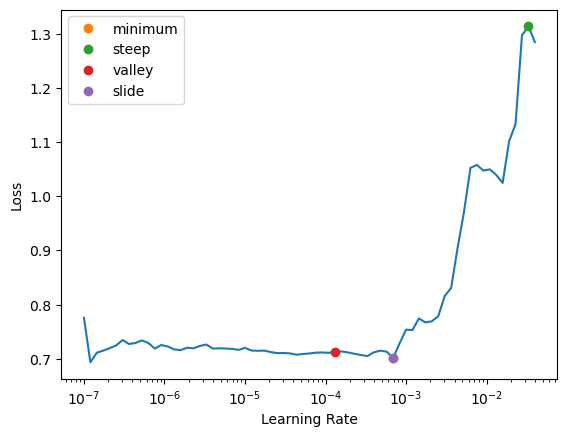

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.659091,0.494033,0.830000,00:27
1,0.203200,0.326645,0.885000,00:27
2,0.220519,0.307744,0.895000,00:25


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.22051946818828583
valid_loss 0.3077441155910492
accuracy 0.8949999809265137


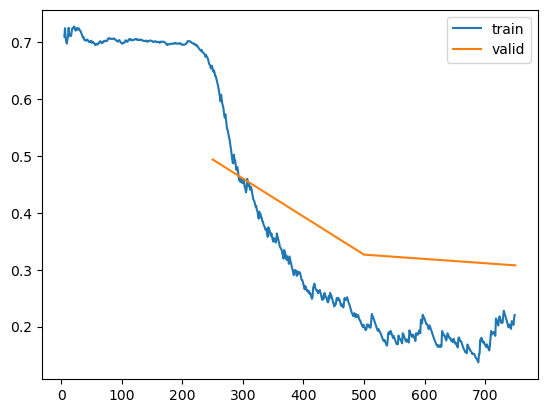

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# YES: Since we're using fastai `TfmDL` and including a transform that knows how to show our inputs,
# we get `show_results()` back
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"I quit watching ""The West Wing"" after Aaron Sorkin quit writing and producing. It just wasn't the same. Imagine my thrill at seeing a film that he wrote again. It has been a long time - The American President, A Few Good Men. His script was a beautiful blend of humor and tragedy. He made a compelling story believable, and made me weep at the same time.<br /><br />Tom Hanks was incredible as a small-time Texas Congressman whose constituents only wanted lower taxes and to keep their guns. Not a ha",pos,pos
1,"Peter O'Toole, one of our finest actors, is magnificent as a reserved school master who is dedicated to teaching young boys. He meets a show girl and falls in love. The story is one of love and devotion. Petula Clark adds spirit and sensitivity, not too mention a remarkable voice. You will enjoy this film even though the ending might not be a happy one. I enjoyed it.",pos,pos


In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_low_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(civil_labels)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Dataset`s

We'll use the Hugging Face `Dataset` objects created in *Setup*, but these could just as well be instances of `torch.utils.data.Dataset`

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    updated_example = dict(hf_tokenizer(example["text"], truncation=True))
    labels = torch.stack([tensor(example[lbl]) for lbl in civil_labels], dim=-1)
    updated_example["label"] = labels

    return updated_example


proc_civil_ds = civil_ds.map(tokenize_func, batched=True)
# proc_imdb_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])


# define dataset splitter
def _split_func(example):
    return example["is_valid"] == True


splitter = FuncSplitter(_split_func)
splits = splitter(proc_civil_ds)


# define how we want to build our inputs and targets
def _build_inputs(example):
    return {fwd_arg_name: example[fwd_arg_name] for fwd_arg_name in hf_tokenizer.model_input_names if fwd_arg_name in list(example.keys())}


def _build_targets(example):
    return example["label"]


# create our fastai `Datasets` object
dsets = Datasets(items=proc_civil_ds, splits=splits, tfms=[[_build_inputs], _build_targets], n_inp=1)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/civil_comments/default/0.9.0/e7a3aacd2ab7d135fa958e7209d10b1fa03807d44c486e3c34897aa08ea8ffab/cache-b6b4124a17f696ae.arrow


##### Step 3: `DataLoaders`

In [ ]:
batch_size = 4

trn_dl = TextDataLoader(
    dsets.train,
    hf_tokenizer,
    batch_decode_kwargs={"labels": civil_labels},
    shuffle=True,
    batch_size=batch_size,
)

val_dl = TextDataLoader(
    dsets.valid,
    hf_tokenizer,
    batch_decode_kwargs={"labels": civil_labels},
    batch_size=batch_size * 2,
)

dls = DataLoaders(trn_dl, val_dl)

In [ ]:
print(len(dls.train), len(dls.valid))

b = dls.valid.one_batch()
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0][:200]))
print("")
print(b[1])

250 25
2

[CLS] All true, sirencall, no matter what side one is on. Well said. But hold up, how can Trump be ignorant of history? Didn't the American people elect him? Doesn't that automatically make him retroactively brilliant on all issues, even those he never cared about or read up on? Isn't that how it works? All magic like.[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]

tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]])


In [ ]:
# YES: Since we're using fastai `TfmDL` and including a transform that knows how to show our inputs,
# we get `show_batch()` back
dls.show_batch(dataloaders=dls, max_n=8)

,text,target
0,"I have yet to see anything about what is actually entailed by this ""vetting"" and ""extreme vetting"", and the difference between those. Does anyone actually know? What do we actually do now, ask people if they are terrorists and take their word for it? If not, do we only make sure they haven't been convicted somewhere of terrorism? Otherwise, the alternative is to actually make some assumptions about people's POTENTIAL for terrorism, and how do ""the authorities"" do that""? I suspect they don't. Details instead of vague but emotional appeals on both sides would be helpful.",[]
1,Will she bite?,[]
2,"I was wondering the same thing. Yes, Seaton is Chair of House Health & Social Services http://www.akleg.gov/basis/Committee/Details/29?code=HHSS",[]
3,Tell it like it is.,[]


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# YES: Since we're using fastai `TfmDL` and including a transform that knows how to show our inputs,
# we get `show_batch()` back
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,"All true, sirencall, no matter what side one is on. Well said. But hold up, how can Trump be ignorant of history? Didn't the American people elect him? Doesn't that automatically make him retroactively brilliant on all issues, even those he never car",[]
1,Charged with misdemeanors? WTH Why wasn't his rifle and any other equipment he used taken from him?,[]


In [ ]:
# YES: Since we're using fastai `DataLoaders`, we get `learn.summary()` back
learn.summary()

BaseModelWrapper (Input shape: 4 x 214)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 214 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 214 x 3072      
Linear                         

##### Step 5: Train

SuggestedLRs(minimum=0.0006309573538601399, steep=0.033113110810518265, valley=7.585775892948732e-05, slide=0.0003981071640737355)

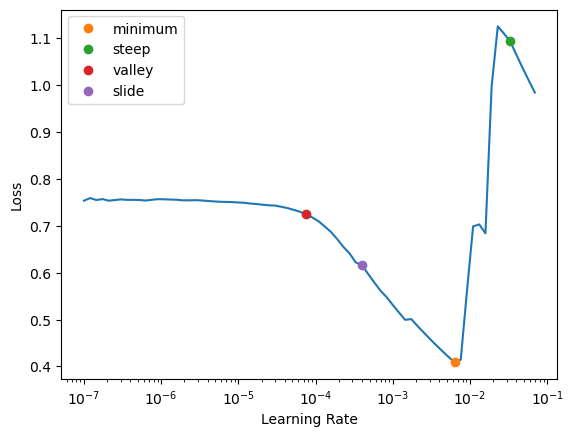

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.152023,0.071213,0.984286,00:19
1,0.083577,0.065612,0.984286,00:17
2,0.066047,0.065015,0.984286,00:17


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.06604747474193573
valid_loss 0.06501486152410507
accuracy_multi 0.9842857122421265


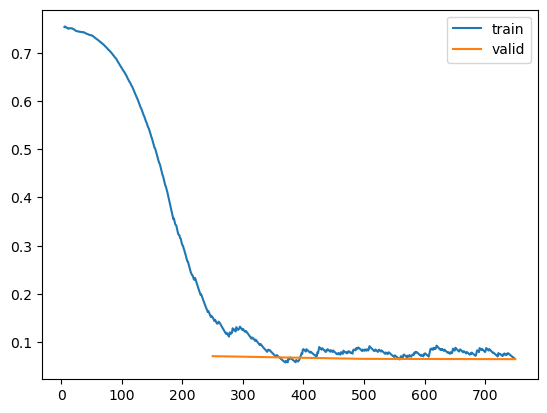

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# YES: Since we're using fastai `TfmDL` and including a transform that knows how to show our inputs,
# we get `show_results()` back
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"And let me suggest the biggest driver of laws and regulations is the failure of what Adam Smith called moral sentiment: ""Concern for our own happiness recommends to us the virtue of prudence, concern for that of other people, the virtues of justice and beneficence of which the one restrains us from hurting, the other prompts... (us) to promote that happiness."" He believed we all carried an 'impartial spectator'. ""The impartial observer represents a consolidation of social values that forms a com",[],[]
1,"Given how much we spend on Healthcare here in Hawaii and across the Nation, our fragmented privatized system is a disgrace. We spend twice that of other developed nations, but our outcomes are at the bottom compared to their single payer systems. Competitive markets are supposed to yield higher-quality for lower-cost. Clearly this is not happening in our health care system where scheming to limit access to quality care is more profitable than delivering it. How long can we afford to keep support",[],[]


In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_low_level_multilabel.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

## Mid-Level API: Data

BLURR's mid-level API provides a way to build your `DataLoaders` using fast.ai's mid-level `DataBlock` API.  

BLURR supports three ways of doing this in the mid-level API: 

1. Using pre-tokenized data (the traditional approach)

2. batch-time tokenization (the default approach in previous versions of blurr)

2. item-time tokenization (e.g., to apply tokenization on individual items as they are pulled from their respective `Dataset`)

### `BatchTokenizeTransform` -

In [ ]:
# |export
class BatchTokenizeTransform(Transform):
    """
    Handles everything you need to assemble a mini-batch of inputs and targets, as well as
    decode the dictionary produced as a byproduct of the tokenization process in the `encodes` method.
    """

    def __init__(
        self,
        # The abbreviation/name of your Hugging Face transformer architecture (e.b., bert, bart, etc..)
        hf_arch: str,
        # A specific configuration instance you want to use
        hf_config: PretrainedConfig,
        # A Hugging Face tokenizer
        hf_tokenizer: PreTrainedTokenizerBase,
        # A Hugging Face model
        hf_model: PreTrainedModel,
        # To control whether the "labels" are included in your inputs. If they are, the loss will be calculated in \
        # the model's forward function and you can simply use `PreCalculatedLoss` as your `Learner`'s loss function to use it
        include_labels: bool = True,
        # The token ID that should be ignored when calculating the loss
        ignore_token_id: int = CrossEntropyLossFlat().ignore_index,
        # To control the length of the padding/truncation. It can be an integer or None, \
        # in which case it will default to the maximum length the model can accept. \
        # If the model has no specific maximum input length, truncation/padding to max_length is deactivated. \
        # See [Everything you always wanted to know about padding and truncation](https://huggingface.co/transformers/preprocessing.html#everything-you-always-wanted-to-know-about-padding-and-truncation)
        max_length: int = None,
        # To control the `padding` applied to your `hf_tokenizer` during tokenization. \
        # If None, will default to 'False' or 'do_not_pad'. \
        # See [Everything you always wanted to know about padding and truncation](https://huggingface.co/transformers/preprocessing.html#everything-you-always-wanted-to-know-about-padding-and-truncation)
        padding: bool | str = True,
        # To control `truncation` applied to your `hf_tokenizer` during tokenization. \
        # If None, will default to 'False' or 'do_not_truncate'. \
        # See [Everything you always wanted to know about padding and truncation](https://huggingface.co/transformers/preprocessing.html#everything-you-always-wanted-to-know-about-padding-and-truncation)
        truncation: bool | str = True,
        # The `is_split_into_words` argument applied to your `hf_tokenizer` during tokenization. \
        # Set this to 'True' if your inputs are pre-tokenized (not numericalized) \
        is_split_into_words: bool = False,
        # Any other keyword arguments you want included when using your `hf_tokenizer` to tokenize your inputs
        tok_kwargs: dict = {},
        # Keyword arguments to apply to `BatchTokenizeTransform`
        **kwargs,
    ):
        store_attr()
        self.kwargs = kwargs

    def encodes(self, samples, return_batch_encoding=False):
        """
        This method peforms on-the-fly, batch-time tokenization of your data. In other words, your raw inputs
        are tokenized as needed for each mini-batch of data rather than requiring pre-tokenization of your full
        dataset ahead of time.
        """
        samples = L(samples)

        # grab inputs
        is_dict = isinstance(samples[0][0], dict)
        test_inp = samples[0][0]["text"] if is_dict else samples[0][0]

        if is_listy(test_inp) and not self.is_split_into_words:
            if is_dict:
                inps = [(item["text"][0], item["text"][1]) for item in samples.itemgot(0).items]
            else:
                inps = list(zip(samples.itemgot(0, 0), samples.itemgot(0, 1)))
        else:
            inps = [item["text"] for item in samples.itemgot(0).items] if is_dict else samples.itemgot(0).items

        inputs = self.hf_tokenizer(
            inps,
            max_length=self.max_length,
            padding=self.padding,
            truncation=self.truncation,
            is_split_into_words=self.is_split_into_words,
            return_tensors="pt",
            **self.tok_kwargs,
        )

        d_keys = inputs.keys()

        # update the samples with tokenized inputs (e.g. input_ids, attention_mask, etc...), as well as extra information
        # if the inputs is a dictionary.
        # (< 2.0.0): updated_samples = [(*[{k: inputs[k][idx] for k in d_keys}], *sample[1:]) for idx, sample in enumerate(samples)]
        updated_samples = []
        for idx, sample in enumerate(samples):
            inps = {k: inputs[k][idx] for k in d_keys}
            if is_dict:
                inps = {
                    **inps,
                    **{k: v for k, v in sample[0].items() if k not in ["text"]},
                }

            trgs = sample[1:]
            if self.include_labels and len(trgs) > 0:
                inps["labels"] = trgs[0]

            updated_samples.append((*[inps], *trgs))

        if return_batch_encoding:
            return updated_samples, inputs

        return updated_samples

Inspired by this [article](https://docs.fast.ai/tutorial.transformers.html), `BatchTokenizeTransform` inputs can come in as raw **text**, **a list of words** (e.g., tasks like Named Entity Recognition (NER), where you want to predict the label of each token), or as a **dictionary** that includes extra information you want to use during post-processing.

**On-the-fly Batch-Time Tokenization**: 

Part of the inspiration for this derives from the mechanics of Hugging Face tokenizers, in particular it can return a collated mini-batch of data given a list of sequences. As such, the collating required for our inputs can be done during tokenization ***before*** our batch transforms run in a `before_batch_tfms` transform (where we get a list of examples)! This allows users of BLURR to have everything done dynamically at batch-time without prior preprocessing with at least four potential benefits:
1. Less code
2. Faster mini-batch creation
3. Less RAM utilization and time spent tokenizing beforehand (this really helps with very large datasets)
4. Flexibility

### `TextBlock` -

In [ ]:
# |export
class TextBlock(TransformBlock):
    """The core `TransformBlock` to prepare your inputs for training in Blurr with fastai's `DataBlock` API"""

    def __init__(
        self,
        # The abbreviation/name of your Hugging Face transformer architecture (not required if passing in an \
        # instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_arch: str = None,
        # A Hugging Face configuration object (not required if passing in an \
        # instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_config: PretrainedConfig = None,
        # A Hugging Face tokenizer (not required if passing in an \
        # instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_tokenizer: PreTrainedTokenizerBase = None,
        # A Hugging Face model (not required if passing in an \
        # instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_model: PreTrainedModel = None,
        # To control whether the "labels" are included in your inputs. If they are, the loss will be calculated in \
        # the model's forward function and you can simply use `PreCalculatedLoss` as your `Learner`'s loss function to use it
        include_labels: bool = True,
        # The token ID that should be ignored when calculating the loss
        ignore_token_id=CrossEntropyLossFlat().ignore_index,
        # The before_batch_tfm you want to use to tokenize your raw data on the fly \
        # (defaults to an instance of `BatchTokenizeTransform`)
        batch_tokenize_tfm: BatchTokenizeTransform = None,
        # The batch_tfm you want to decode your inputs into a type that can be used in the fastai show methods, \
        # (defaults to BatchDecodeTransform)
        batch_decode_tfm: BatchDecodeTransform = None,
        # To control the length of the padding/truncation. It can be an integer or None, \
        # in which case it will default to the maximum length the model can accept. If the model has no \
        # specific maximum input length, truncation/padding to max_length is deactivated. \
        # See [Everything you always wanted to know about padding and truncation](https://huggingface.co/transformers/preprocessing.html#everything-you-always-wanted-to-know-about-padding-and-truncation)
        max_length: int = None,
        # To control the 'padding' applied to your `hf_tokenizer` during tokenization. \
        # If None, will default to 'False' or 'do_not_pad'. \
        # See [Everything you always wanted to know about padding and truncation](https://huggingface.co/transformers/preprocessing.html#everything-you-always-wanted-to-know-about-padding-and-truncation)
        padding: bool | str = True,
        # To control 'truncation' applied to your `hf_tokenizer` during tokenization. \
        # If None, will default to 'False' or 'do_not_truncate'. \
        # See [Everything you always wanted to know about padding and truncation](https://huggingface.co/transformers/preprocessing.html#everything-you-always-wanted-to-know-about-padding-and-truncation)
        truncation: bool | str = True,
        # The `is_split_into_words` argument applied to your `hf_tokenizer` during tokenization. \
        # Set this to `True` if your inputs are pre-tokenized (not numericalized)
        is_split_into_words: bool = False,
        # The return type your decoded inputs should be cast too (used by methods such as `show_batch`)
        input_return_type: type = TextInput,
        # The type of `DataLoader` you want created (defaults to `SortedDL`)
        dl_type: DataLoader = None,
        # Any keyword arguments you want applied to your `batch_tokenize_tfm`
        batch_tokenize_kwargs: dict = {},
        # Any keyword arguments you want applied to your `batch_decode_tfm` (will be set as a fastai `batch_tfms`)
        batch_decode_kwargs: dict = {},
        # Any keyword arguments you want your Hugging Face tokenizer to use during tokenization
        tok_kwargs: dict = {},
        # Any keyword arguments you want to have applied with generating text
        text_gen_kwargs: dict = {},
        # Any keyword arguments you want applied to `TextBlock`
        **kwargs,
    ):
        if (not all([hf_arch, hf_config, hf_tokenizer, hf_model])) and batch_tokenize_tfm is None:
            raise ValueError("You must supply an hf_arch, hf_config, hf_tokenizer, hf_model -or- a BatchTokenizeTransform")

        if batch_tokenize_tfm is None:
            batch_tokenize_tfm = BatchTokenizeTransform(
                hf_arch,
                hf_config,
                hf_tokenizer,
                hf_model,
                include_labels=include_labels,
                ignore_token_id=ignore_token_id,
                max_length=max_length,
                padding=padding,
                truncation=truncation,
                is_split_into_words=is_split_into_words,
                tok_kwargs=tok_kwargs.copy(),
                **batch_tokenize_kwargs.copy(),
            )

        if batch_decode_tfm is None:
            batch_decode_tfm = BatchDecodeTransform(
                hf_tokenizer=hf_tokenizer, input_return_type=input_return_type, **batch_decode_kwargs.copy()
            )

        if dl_type is None:
            dl_sort_func = partial(
                sorted_dl_func,
                hf_tokenizer=batch_tokenize_tfm.hf_tokenizer,
                is_split_into_words=batch_tokenize_tfm.is_split_into_words,
                tok_kwargs=batch_tokenize_tfm.tok_kwargs.copy(),
            )

            dl_type = partial(SortedDL, sort_func=dl_sort_func)

        return super().__init__(
            dl_type=dl_type,
            dls_kwargs={"before_batch": batch_tokenize_tfm},
            batch_tfms=batch_decode_tfm,
        )

## Mid-Level API: Examples

### Batch-Time Tokenization

#### Multiclass

##### Step 1: HF objects.

In [ ]:
# | output: false
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(label_names)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#####  Step 2: `DataBlock`

In [ ]:
blocks = (
    TextBlock(
        hf_arch,
        hf_config,
        hf_tokenizer,
        hf_model,
        batch_tokenize_kwargs={"labels": label_names},
    ),
    CategoryBlock,
)
dblock = DataBlock(
    blocks=blocks,
    get_x=ColReader("text"),
    get_y=ColReader("label"),
    splitter=ColSplitter(),
)

##### Step 3: `DataLoaders`

In [ ]:
dls = dblock.dataloaders(imdb_df, bs=4)

In [ ]:
b = dls.one_batch()
len(b), len(b[0]["input_ids"]), b[0]["input_ids"].shape, len(b[1])

(2, 4, torch.Size([4, 1332]), 4)

In [ ]:
b[0]

{'input_ids': tensor([[    1, 84539,   430,  ...,   966,   260,     2],
         [    1,  1781, 31892,  ...,     0,     0,     0],
         [    1,   329,  4773,  ...,     0,     0,     0],
         [    1,   367,   387,  ...,     0,     0,     0]], device='cuda:0'),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'),
 'labels': TensorCategory([0, 1, 0, 1], device='cuda:0')}

Let's take a look at the actual types represented by our batch

In [ ]:
explode_types(b)

{tuple: [dict, fastai.torch_core.TensorCategory]}

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,text,target
0,"SPOILERS HEREIN<br /><br />My High School did all they could to try and motivate us for exams. But the most memorable method they used to get us into the right state of mind was a guest speaker, who was none other than Australian Kickboxing's favorite son, Stan ""The Man"" Longinidis. The first mistake they made was giving this guy a microphone, because he was screaming half the time despite us sitting no more than 3 or 4 feet away from him. Now, his speech was full of the usual ""if you fail to pr",0
1,"It's always difficult to put a stamp on any film as being 'the best,' whether of all time, a certain genre, or what have you, but I believe a strong argument could be made that in fact, Laputa is the greatest animated film ever made. It is in my mind the masterwork of Hayao Miyazaki, the most talented of Japan's animated directors, and it best captures his strengths as a director, storyteller, and designer, as well as encapsulating all of his favorite underlying themes. The version I'm reviewing",1


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,"In the light of the recent typhoon that hit the country hard (that is, typhoon Ondoy), I thought it upon myself to re-watch ""Black Rain"" (1988, Japan), Shohei Imamura's haunting black-and-white masterpiece on the destruction and after-effects of the",1
1,"It would seem we should acknowledge Scandinavian cinema for more than merely the Dogma 1995 movement as cooked up by the Danish all those years ago. Den Brysomme Mannen, or The Bothersome Man in English, is a surreal and deeply thought through film y",1


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 1332)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 1332 x 768      
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 1332 x 3072     
Linear                        

##### Step 5: Train

SuggestedLRs(minimum=3.311311274956097e-07, steep=1.3182567499825382e-06, valley=4.365158383734524e-05, slide=0.0008317637839354575)

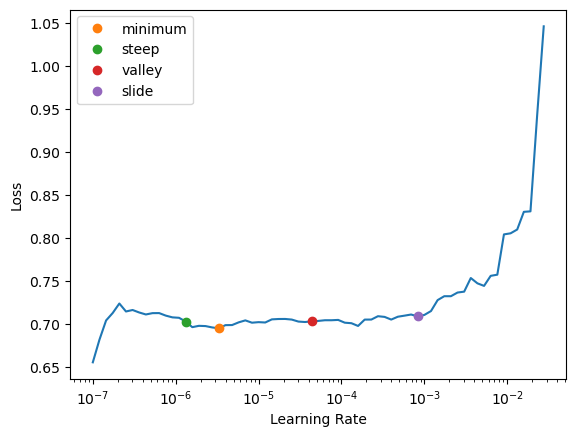

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.671701,0.599220,0.700000,00:20
1,0.247916,0.266826,0.890000,00:20
2,0.180813,0.281944,0.895000,00:20


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.1808129847049713
valid_loss 0.2819436490535736
accuracy 0.8949999809265137


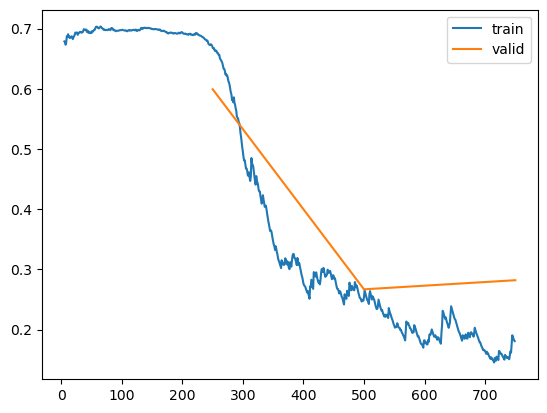

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"In the light of the recent typhoon that hit the country hard (that is, typhoon Ondoy), I thought it upon myself to re-watch ""Black Rain"" (1988, Japan), Shohei Imamura's haunting black-and-white masterpiece on the destruction and after-effects of the atomic bomb that hit Hiroshima in the closing period of the Second World War. The destruction and impact of both catastrophes (war and typhoon) may differ in degree and quality, but the trauma and scar (physically and psychologically) nevertheless ar",1,1
1,"It would seem we should acknowledge Scandinavian cinema for more than merely the Dogma 1995 movement as cooked up by the Danish all those years ago. Den Brysomme Mannen, or The Bothersome Man in English, is a surreal and deeply thought through film yet deeply entertaining and rich in content both on and under the surface. As a film alone, it is a scathing comedy on society and attitudes in the post-modern world we live in; a world that judging by The Bothersome Man has reached the regions of Nor",1,1


In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects.

In [ ]:
# | output: false
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(civil_labels)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#####  Step 2: `DataBlock`

In [ ]:
blocks = (TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), MultiCategoryBlock(encoded=True, vocab=civil_labels))
dblock = DataBlock(blocks=blocks, get_x=ColReader("text"), get_y=ColReader(civil_labels), splitter=ColSplitter())

##### Step 3: `DataLoaders`

In [ ]:
dls = dblock.dataloaders(civil_df, bs=4)

In [ ]:
b = dls.one_batch()
len(b), b[0]["input_ids"].shape, b[1].shape

(2, torch.Size([4, 263]), torch.Size([4, 7]))

In [ ]:
b[0]

{'input_ids': tensor([[     1,    307,   8803,  ...,   1026,    260,      2],
         [     1,   6297,    269,  ...,      0,      0,      0],
         [     1, 122307,   3735,  ...,      0,      0,      0],
         [     1,  24693,    682,  ...,      0,      0,      0]],
        device='cuda:0'),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'),
 'labels': TensorMultiCategory([[0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')}

Let's take a look at the actual types represented by our batch

In [ ]:
explode_types(b)

{tuple: [dict, fastai.torch_core.TensorMultiCategory]}

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,text,target
0,"""after all your calculation, 'could easily be billions' seems like a number pulled from the air"" Not really. From: http://money.cnn.com/2017/11/03/real_estate/mortgage-interest-deduction-cap-tax-bill ""So far this year, 5.4% of all loans originated were more than $500,000,... or about 325,000 loans"" That's ""so far this year"". If we extrapolate to the full year, that's 390,000 loans per year more than $500k (presuming Nov-Dec are comparable to Jan-Oct). If the loan amount averages just $550k, at 4",[]
1,"A bike tax is an interesting proposition. Many motorists believe cyclists should pay their fair share for use of roads. What would the tax look like? To estimate revenue, assume a cyclist rides on average 1500 miles a year. At the current gas tax a car getting 25 mpg pays about 1.2 cents per mile. Do we tax at the mpg rate for bikes which get a 700 mpg equivalent? Let's just tax at the 1.2 rate motorists pay. That 1500 miles a year generates $18 per cyclist. Round that up to a $20 yearly fee. Ho",[]


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),  # PreCalculatedBCELoss()
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,"And let me suggest the biggest driver of laws and regulations is the failure of what Adam Smith called moral sentiment: ""Concern for our own happiness recommends to us the virtue of prudence, concern for that of other people, the virtues of justice a",[]
1,"1) I use a screen name because this is a small island and I am not interested in being stalked, singled out, or harassed for my views. I also find that if you mention any personal detail on these boards, it is used to invalidate any opinion you may h",[]


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 263)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 263 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 263 x 3072      
Linear                         

##### Step 5: Train

SuggestedLRs(minimum=0.0005248074419796466, steep=0.009120108559727669, valley=9.120108734350652e-05, slide=0.0012022644514217973)

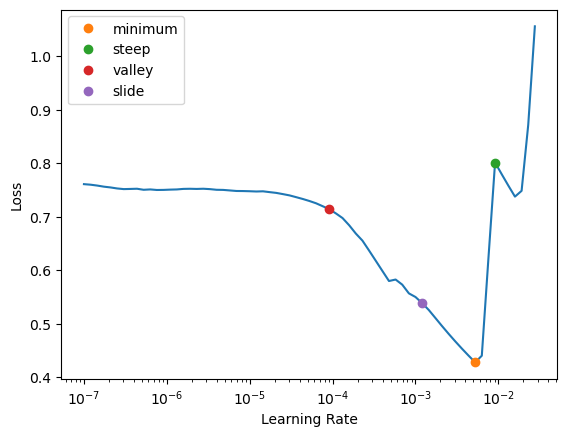

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.151901,0.068548,0.984286,00:17
1,0.070199,0.064646,0.984286,00:17
2,0.077689,0.063061,0.984286,00:17


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.07768901437520981
valid_loss 0.06306090205907822
accuracy_multi 0.9842857122421265


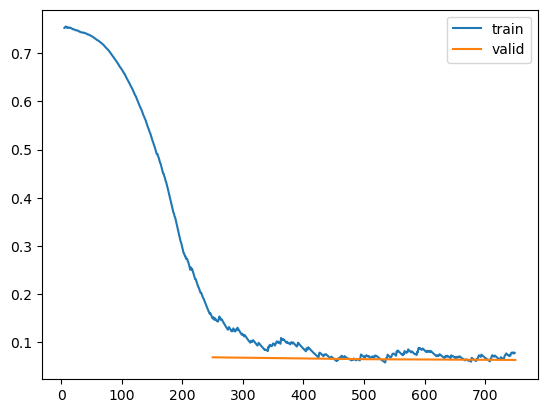

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"And let me suggest the biggest driver of laws and regulations is the failure of what Adam Smith called moral sentiment: ""Concern for our own happiness recommends to us the virtue of prudence, concern for that of other people, the virtues of justice and beneficence of which the one restrains us from hurting, the other prompts... (us) to promote that happiness."" He believed we all carried an 'impartial spectator'. ""The impartial observer represents a consolidation of social values that forms a com",[],[]
1,"1) I use a screen name because this is a small island and I am not interested in being stalked, singled out, or harassed for my views. I also find that if you mention any personal detail on these boards, it is used to invalidate any opinion you may have. So, no. 2) I think you need to look at your source again. The ""just $218 per family"" is a'myth' on the HART site that the Tax Foundation of Hawaii is ""busting."" From the page: ""$200, is the surcharge they can see. But there is a massive amount o",[],[]


In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test.pkl")

In [ ]:
# learn.loss_func.thresh = 0.02


# comment = """
# Those damned affluent white people should only eat their own food, like cod cakes and boiled potatoes.
# No enchiladas for them!
# """
# learn.blurr_predict(comment)

In [ ]:
# preds, targs, losses = learn.get_preds(with_loss=True)
# preds.shape, targs.shape, losses.shape

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

## Inference

We need to replace fastai's `Learner.predict` method with the one above which is able to work with inputs that are represented by multiple tensors included in a dictionary.

In [ ]:
# |export
@patch
def blurr_predict(self: Learner, items, rm_type_tfms=None, tok_is_split_into_words=False):
    # grab our blurr tfm with the bits to properly decode/show our inputs/targets
    tfm = first_blurr_tfm(self.dls)
    batch_tok_tfm = get_blurr_tfm(dls.before_batch, tfm_class=BatchTokenizeTransform)

    hf_tokenizer = tfm.hf_tokenizer
    trg_labels = tfm.kwargs["labels"] if ("labels" in tfm.kwargs) else None

    is_split_into_words = getattr(tfm, "is_split_into_words", tok_is_split_into_words)
    is_split_str = is_split_into_words == True and isinstance(items[0], str)
    is_df = isinstance(items, pd.DataFrame)

    if not is_df and (is_split_str or not is_listy(items)):
        items = [items]

    # we need to tokenize our items *if* we are not using the mid-level API batch-time tokenization
    if batch_tok_tfm is None:
        inputs_d = dict(
            hf_tokenizer(
                items, is_split_into_words=is_split_into_words, padding=True, max_length=True, truncation=True, return_tensors="pt"
            )
        )
        items = [{k: inputs_d[k][idx] for k in inputs_d.keys()} for idx in range(len(inputs_d["input_ids"]))]

    dl = self.dls.test_dl(items, rm_type_tfms=rm_type_tfms, num_workers=0)

    with self.no_bar():
        probs, _, decoded_preds = self.get_preds(dl=dl, with_input=False, with_decoded=True)

    trg_tfms = self.dls.tfms[self.dls.n_inp :]

    outs = []
    is_multilabel = isinstance(self.loss_func, BCEWithLogitsLossFlat)
    probs, decoded_preds = L(probs), L(decoded_preds)
    for i in range(len(items)):
        item_probs = probs.itemgot(i)
        item_dec_preds = decoded_preds.itemgot(i)
        item_dec_labels = tuplify([tfm.decode(item_dec_preds[tfm_idx]) for tfm_idx, tfm in enumerate(trg_tfms)])[0]

        if trg_labels:
            # handle multiclass output
            if len(item_dec_labels.size()) == 0:
                item_dec_labels = [item_dec_labels.item()]
            # handle multilabel output
            else:
                item_dec_labels = [trg_labels[lbl_idx] for lbl_idx, lbl in enumerate(item_dec_labels) if lbl == True]

        res = {}
        if is_multilabel:
            res["labels"] = list(item_dec_labels)
            msk = item_dec_preds[0]
            res["scores"] = item_probs[0][msk].tolist()
            res["class_indices"] = [int(val) for val in item_dec_preds[0]]
        else:
            res["label"] = item_dec_labels[0]
            res["score"] = item_probs[0].tolist()[item_dec_preds[0]]
            res["class_index"] = item_dec_preds[0].item()

        if trg_labels is not None or hasattr(self.dls, "vocab"):
            res["class_labels"] = trg_labels if trg_labels else self.dls.vocab
        else:
            res["class_labels"] = None

        res["probs"] = item_probs[0].tolist()

        outs.append(res)
    return outs

In [ ]:
nbdev.show_doc(Learner.blurr_predict)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/core.py#L503){target="_blank" style="float:right; font-size:smaller"}

### Learner.blurr_predict

>      Learner.blurr_predict (items, rm_type_tfms=None,
>                             tok_is_split_into_words=False)

In [ ]:
inf_learn = load_learner("../models/test_text_core_low_level.pkl")

In [ ]:
inf_learn.blurr_predict("This is perhaps the best movie I have ever seen!!!")

[{'label': 1,
  'score': 0.6871640086174011,
  'class_index': 1,
  'class_labels': ['neg', 'pos'],
  'probs': [0.3128359913825989, 0.6871640086174011]}]

In [ ]:
inf_learn.blurr_predict("Acting was so bad it was almost funny.")

[{'label': 0,
  'score': 0.735758364200592,
  'class_index': 0,
  'class_labels': ['neg', 'pos'],
  'probs': [0.735758364200592, 0.26424163579940796]}]

In [ ]:
inf_learn.blurr_predict(["I really liked the movie", "Worse movie I ever saw"])

[{'label': 1,
  'score': 0.6988857388496399,
  'class_index': 1,
  'class_labels': ['neg', 'pos'],
  'probs': [0.3011142611503601, 0.6988857388496399]},
 {'label': 0,
  'score': 0.5338910818099976,
  'class_index': 0,
  'class_labels': ['neg', 'pos'],
  'probs': [0.5338910818099976, 0.46610888838768005]}]

In [ ]:
inf_learn = load_learner("../models/test_text_core_low_level_multilabel.pkl")

In [ ]:
inf_learn.blurr_predict("I will tell everyone what you did if you tell you jerk!")

[{'labels': [],
  'scores': [],
  'class_indices': [0, 0, 0, 0, 0, 0, 0],
  'class_labels': ['toxicity',
   'severe_toxicity',
   'obscene',
   'threat',
   'insult',
   'identity_attack',
   'sexual_explicit'],
  'probs': [0.061660122126340866,
   0.0009812690550461411,
   0.002641950733959675,
   0.0014976297970861197,
   0.034202881157398224,
   0.005786544177681208,
   0.0018320769304409623]}]

In [ ]:
# |echo:false
try:
    del inf_learn
except:
    pass
finally:
    clean_memory()

## Text Generation

With regards to **text generation**, though not useful in sequence classification, we will also add a `blurr_generate` method to `Learner` that uses Hugging Face's `PreTrainedModel.generate` for text generation tasks.  

For the full list of arguments you can pass in see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate). You can also check out their ["How To Generate"](https://github.com/huggingface/blog/blob/master/notebooks/02_how_to_generate.ipynb) notebook for more information about how it all works.

In [ ]:
# |export
@patch
def blurr_generate(self: Learner, items, key="generated_texts", **kwargs):
    """Uses the built-in `generate` method to generate the text
    (see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate)
    for a list of arguments you can pass in)
    """
    if not is_listy(items):
        items = [items]

    # grab our blurr tfm with the bits to properly decode/show our inputs/targets
    tfm = first_blurr_tfm(self.dls)

    # grab the Hugging Face tokenizer from the learner's dls.tfms
    hf_tokenizer = tfm.hf_tokenizer
    tok_kwargs = tfm.tok_kwargs

    # grab the text generation kwargs
    text_gen_kwargs = tfm.text_gen_kwargs if (len(kwargs) == 0) else kwargs

    results = []
    for idx, inp in enumerate(items):
        if isinstance(inp, str):
            input_ids = hf_tokenizer.encode(inp, padding=True, truncation=True, return_tensors="pt", **tok_kwargs)
        else:
            # note (10/30/2020): as of pytorch 1.7, this has to be a plain ol tensor (not a subclass of TensorBase)
            input_ids = inp.as_subclass(Tensor)

        input_ids = input_ids.to(self.model.hf_model.device)

        gen_texts = self.model.hf_model.generate(input_ids, **text_gen_kwargs)
        outputs = [hf_tokenizer.decode(txt, skip_special_tokens=True, clean_up_tokenization_spaces=False) for txt in gen_texts]

        if tfm.hf_arch == "pegasus":
            outputs = [o.replace("<n>", " ") for o in outputs]

        results.append({key: outputs[0] if len(outputs) == 1 else outputs})

    return results

In [ ]:
nbdev.show_doc(Learner.blurr_generate)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/core.py#L566){target="_blank" style="float:right; font-size:smaller"}

### Learner.blurr_generate

>      Learner.blurr_generate (items, key='generated_texts', **kwargs)

Uses the built-in `generate` method to generate the text
(see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate)
for a list of arguments you can pass in)

### Tests

The tests below to ensure the core DataBlock code above works for **all** pretrained sequence classification models available in Hugging Face.  These tests are excluded from the CI workflow because of how long they would take to run and the amount of data that would be required to download.

**Note**: Feel free to modify the code below to test whatever pretrained classification models you are working with ... and if any of your pretrained sequence classification models fail, please submit a github issue *(or a PR if you'd like to fix it yourself)*

## Export -

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()